In [1]:
# Standard Library Imports
import os
import sys
from typing import List, Any, Callable, Union, Tuple, Optional
from importlib import reload
from functools import partial
from glob import glob
import cftime
import string
# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import cartopy.crs as ccrs
from matplotlib.ticker import MaxNLocator

# Custom Module Imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'zecmip_stabilisation'))
import constants
sys.path.append(constants.MODULE_DIR)
import open_zecmip
import utils
import plotting_functions
import zec_calculation_functions
import sn_plotting
import my_stats
import signal_to_noise_calculations as sn_calc
logger = utils.get_notebook_logger()
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary cache directory at /jobfs/124047115.gadi-pbs/matplotlib-f_d0vh1g because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import matplotlib.patches as mpatches

In [3]:
constants.MODULE_DIR

'/home/563/ab2313/Documents/zecmip_stabilisation/src'

In [4]:
np.set_printoptions(precision=2, suppress=True, edgeitems=1)
xr.set_options(display_expand_data=False)

In [5]:
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'list_xarray'))
from listXarray import listXarray

In [6]:
# client.close()

In [7]:
# from dask.distributed import Client
# client = Client()
# client

# Opening Data

In [8]:
chunks = {'lat':-1, 'lon':-1, 'time':-1, 'ensemble':-1}

In [9]:
a1_raw_xrlist = open_zecmip.extract_experiment_into_xrlist('1000pgc', 'tas', chunks=chunks, logginglevel='ERROR'
                                                          ).to_dataarray('tas').sort_by_refkey()

In [10]:
pct_raw_xrlist = open_zecmip.extract_experiment_into_xrlist('1pct', 'tas', chunks=chunks).to_dataarray('tas').sort_by_refkey()

In [11]:
esmpi_raw_xrlist = (open_zecmip.extract_experiment_into_xrlist('picontrol', 'tas', chunks=chunks, logginglevel='INFO')
                    .to_dataarray('tas')
                    .isel(ensemble=0)
                    .squeeze('ensemble')
                    .sort_by_refkey()
                    .rename({'latitude':'lat', 'longitude': 'lon'}))

- ACCESS-ESM1-5
-      r1i1p1f1 - /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/tas/gn/v20210316/*.nc
- CanESM5
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p1f1/Amon/tas/gn/v20190429/*.nc
-      r1i1p2f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p2f1/Amon/tas/gn/v20190429/*.nc
- MIROC-ES2L
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/tas/gn/v20190823/*.nc
- UKESM1-0-LL
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/tas/gn/v20200828/*.nc
- MPI-ESM1-2-LR
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r1i1p1f1/Amon/tas/gn/v20190710/*.nc
-      r2i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r2i1p1f1/Amon/tas/gn/v20190815/*.nc
- GISS-E2-1-G-CC
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G-CC/piControl/r1i1p1f1/Amon/tas/gn/v2

In [12]:
# Match all the ensemble dimensions
pct_raw_xrlist = pct_raw_xrlist.cross_match_dim(a1_raw_xrlist, 'ensemble')
a1_raw_xrlist = a1_raw_xrlist.cross_match_dim(pct_raw_xrlist, 'ensemble')

In [13]:
# Only selecting one ensemble member for each model
a1_raw_xrlist = a1_raw_xrlist.isel(ensemble=0)#.chunk('auto')
pct_raw_xrlist = pct_raw_xrlist.isel(ensemble=0)#.chunk('auto')
esmpi_raw_xrlist = esmpi_raw_xrlist.isel(ensemble=0)#.chunk('auto')

In [14]:
# After the year 1000 all values appear to be 0
#esmpi_raw_xrlist['CanESM5'] = esmpi_raw_xrlist['CanESM5'].isel(time=slice(None,1000))

In [15]:
a1_raw_xrlist

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'time': 1212, 'lat': 145, 'lon': 192})
              (Array: 128.72, Chunk: 128.72Mib) ({'model': (1,), 'time': (1212,), 'lat': (145,), 'lon': (192,)})
CESM2          (dataArray): ({'model': 1, 'time': 1800, 'lat': 192, 'lon': 288})
              (Array: 379.69, Chunk: 126.56Mib) ({'model': (1,), 'time': (600, 600, 600), 'lat': (192,), 'lon': (288,)})
CanESM5        (dataArray): ({'model': 1, 'time': 1200, 'lat': 64, 'lon': 128})
              (Array: 37.50, Chunk: 37.5Mib) ({'model': (1,), 'time': (1200,), 'lat': (64,), 'lon': (128,)})
GFDL-ESM4      (dataArray): ({'model': 1, 'time': 2400, 'lat': 180, 'lon': 288})
              (Array: 474.61, Chunk: 237.3Mib) ({'model': (1,), 'time': (1200, 1200), 'lat': (180,), 'lon': (288,)})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'time': 2160, 'lat': 90, 'lon': 144})
              (Array: 106.79, Chunk: 18.39Mib) ({'model': (1,), 'time': (372, 600, 600, 588), 'lat': (

In [16]:
esmpi_raw_xrlist['CanESM5']

<xarray.DataArray 'tas' (model: 1, time: 16800, lat: 64, lon: 128)> Size: 551MB
dask.array<chunksize=(1, 2400, 64, 128), meta=np.ndarray>
Coordinates:
  * time      (time) object 134kB 5201-01-16 12:00:00 ... 6600-12-16 12:00:00
  * lat       (lat) float64 512B -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon       (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * model     (model) <U7 28B 'CanESM5'
    ensemble  <U8 32B 'r1i1p1f1'
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        ST+273.16, CMIP_table_comment: near-surface (usually, 2 m...
    units:          K
    original_name:  ST
    history:        degctok 2019-04-30T17:18:16Z altered by CMOR: Treated sca...
    cell_methods:   area: time: mean
    cell_measures:  area: areacella

# Calculations

##  Data Processing and Mean Calculation

In [17]:
# Convert to celcius
a1_raw_xrlist = a1_raw_xrlist - 273.15
pct_raw_xrlist = pct_raw_xrlist - 273.15
esmpi_raw_xrlist = esmpi_raw_xrlist - 273.15

In [18]:
esmpi_regrid_xrlist = esmpi_raw_xrlist.regrid('MPI-ESM1-2-LR', 'bilinear').set_refkeys('model')
pct_regrid_xrlist = pct_raw_xrlist.regrid('MPI-ESM1-2-LR', 'bilinear').set_refkeys('model')
a1_regrid_xrlist = a1_raw_xrlist.regrid('MPI-ESM1-2-LR', 'bilinear').set_refkeys('model')

In [19]:
# Making the data yearly
esmpi_xrlist = esmpi_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')#.chunk('auto')
pct_xrlist = pct_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')#.chunk('auto')
a1_xrlist = a1_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')#.chunk('auto')

In [20]:
a1_xrlist

key_dim = model


Number of da/ds: 9
---------------
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'time': 185, 'lat': 96, 'lon': 192})
              (Array: 13.01, Chunk: 1.41Mib) ({'model': (1,), 'time': (20, 20, 20, 20, 20, 20, 20, 20, 20, 5), 'lat': (96,), 'lon': (192,)})
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'time': 101, 'lat': 96, 'lon': 192})
              (Array: 14.20, Chunk: 14.2Mib) ({'model': (1,), 'time': (101,), 'lat': (96,), 'lon': (192,)})
CESM2          (dataArray): ({'model': 1, 'time': 150, 'lat': 96, 'lon': 192})
              (Array: 21.09, Chunk: 7.03Mib) ({'model': (1,), 'time': (50, 50, 50), 'lat': (96,), 'lon': (192,)})
CanESM5        (dataArray): ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
              (Array: 14.06, Chunk: 14.06Mib) ({'model': (1,), 'time': (100,), 'lat': (96,), 'lon': (192,)})
GFDL-ESM4      (dataArray): ({'model': 1, 'time': 200, 'lat': 96, 'lon': 192})
              (Array: 28.12, Chunk: 14.06Mib) ({'model': (1,), 'time': (100, 100), 'lat': (96,), '

In [21]:
# Subsetting to only first 150 years so all models have equal footing

# Reduce time so that the smalles time densions matches. This is at 101 years
# a1_xrlist = a1_xrlist.isel(time=slice(None, 100))
# a1_xrlist

In [22]:
# The global weighted mean
pct_smean_xrlist = pct_xrlist.apply(my_stats.space_mean)
a1_smean_xrlist = a1_xrlist.apply(my_stats.space_mean)
esmpi_smean_xrlist = esmpi_xrlist.apply(my_stats.space_mean)

model
model
model


In [23]:
%%time
esmpi_smean_xrlist = esmpi_smean_xrlist.compute()
a1_smean_xrlist = a1_smean_xrlist.compute()
pct_smean_xrlist = pct_smean_xrlist.compute()

CPU times: user 3min 37s, sys: 36.7 s, total: 4min 14s
Wall time: 2min 26s


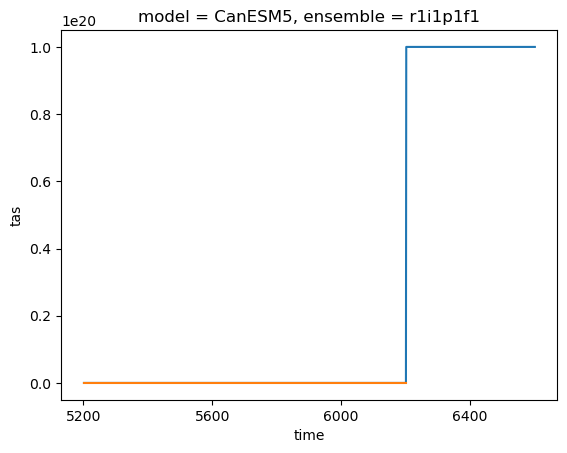

In [24]:
esmpi_smean_xrlist['CanESM5'].plot()
esmpi_smean_xrlist['CanESM5'].isel(time=slice(None, 1000)).plot()

In [25]:
esmpi_smean_xrlist['CanESM5'] = esmpi_smean_xrlist['CanESM5'].isel(time=slice(None, 1000))

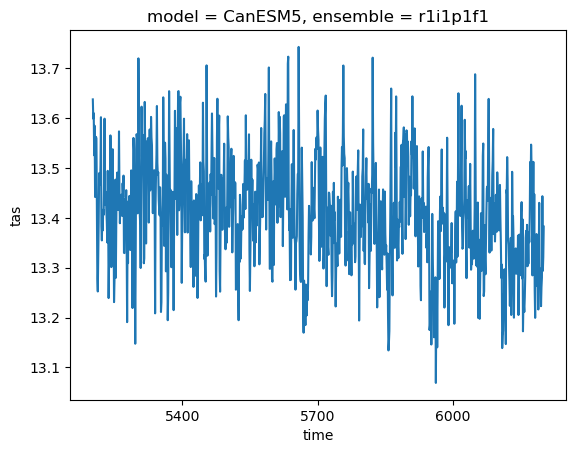

In [26]:
esmpi_smean_xrlist['CanESM5'].plot()

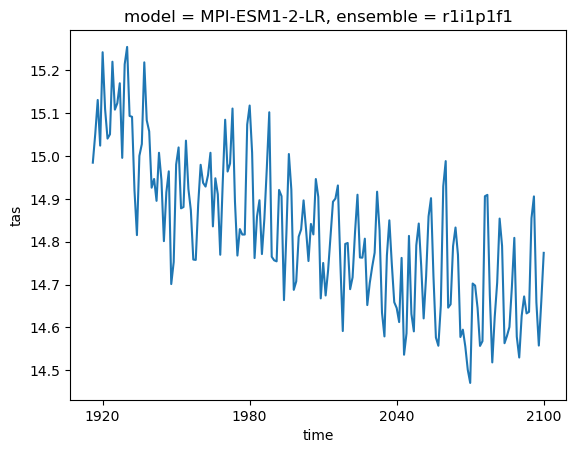

In [27]:
a1_smean_xrlist[0].plot()

In [28]:
# Calculate the values at the branching point
branch_point_mean_xrlist = listXarray([zec_calculation_functions.calculate_branch_average(
    pct_smean_xrlist[model], a1_smean_xrlist[model], logginglevel='INFO') for model in pct_smean_xrlist.refkeys]).set_refkeys('model')

- ['MPI-ESM1-2-LR'] - ['MPI-ESM1-2-LR']
- branch_start_time=cftime.DatetimeProlepticGregorian(1915, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=65
- 

- ['ACCESS-ESM1-5'] - ['ACCESS-ESM1-5']
- branch_start_time=cftime.DatetimeProlepticGregorian(168, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- ['CESM2'] - ['CESM2']
- branch_start_time=cftime.DatetimeNoLeap(68, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- ['CanESM5'] - ['CanESM5']
- branch_start_time=cftime.DatetimeNoLeap(1911, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=61
- 

- ['GFDL-ESM4'] - ['GFDL-ESM4']
- branch_start_time=cftime.DatetimeNoLeap(64, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=63
- 

- ['GISS-E2-1-G-CC'] - ['GISS-E2-1-G-CC']
- branch_start_time=cftime.DatetimeNoLeap(1920, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=70
- 

- ['MIROC-ES2L'] - ['MIROC-ES2L']
- branch_start_time=cftime.DatetimeGregorian(1913, 

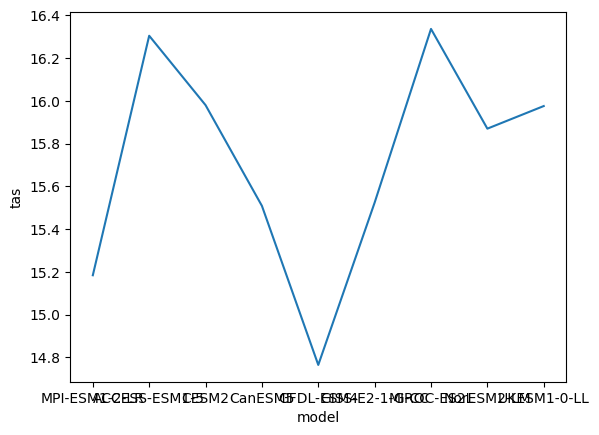

In [29]:
branch_point_mean_xrlist.concat('model').plot()

In [30]:
# The amomaly time series from the branch point
a1_smean_anom_xrlist = (a1_smean_xrlist - branch_point_mean_xrlist).compute()
#a1_smean_anom_xrlist_pre_combine

In [31]:
# ### Adding a small section of the pct data to the a1 data so the central point can be taken.

# a1_smean_anom_list = []
# for model in a1_smean_anom_xrlist_pre_combine.refkeys:
#     a1_model_ds = a1_smean_anom_xrlist_pre_combine.sel(model=model)
#     pct_model_ds = pct_smean_xrlist.sel(model=model)
#     print(model)
#     initial_time_lenght = len(a1_model_ds.time.values)
#     inital_first_time_vals = a1_model_ds.time.dt.year.values[:5]

#     branch_year = a1_model_ds.time[0].dt.year.values.item()
    
#     half_window = int(np.ceil(np.max(windows)/2))
    
#     a1_addition_pct = pct_model_ds.sel(time=pct_model_ds.time.dt.year.isin(np.arange(branch_year-half_window, branch_year)))
#     # a1_addition_pct = a1_addition_pct - branch_point_mean_xrlist[model]
#     # No longer using - fill with nans
#     a1_addition_pct = xr.zeros_like(a1_addition_pct) + np.nan

#     a1_model_ds = a1_model_ds.combine_first(a1_addition_pct)#.plot()
#     a1_smean_anom_list.append(a1_model_ds)

# a1_smean_anom_xrlist = listXarray(a1_smean_anom_list, 'model')

In [32]:
# All modles now have matching coordinates - can now be converted to xarray
# previosly a1 was a1_smean_anom_xrlist
a1_smean_anom_ds = a1_smean_anom_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model').drop('ensemble')
a1_smean_ds = a1_smean_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model').drop('ensemble')
pct_smean_ds = pct_smean_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model').drop('ensemble')
esmpi_smean_ds = esmpi_smean_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model').drop('ensemble')

model
model
model
model


In [33]:
a1_smean_anom_ds['time'] = a1_smean_anom_ds.time.dt.year.values# - half_window

In [34]:
a1_smean_anom_ds.time.values[-3:], a1_smean_anom_ds.time.values[:3]

(array([328, 329, 330]), array([1, 2, 3]))

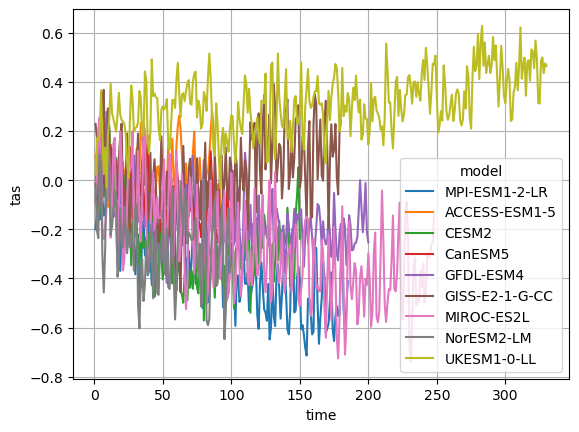

In [35]:
a1_smean_anom_ds.plot(hue='model');
plt.grid()

In [36]:
# This way procudes the same as when you average first then take the anomalies. However, we also get the anomaleis
# time series which is useful
zec25_ds = a1_smean_anom_ds.isel(time=slice(15, 35)).mean(dim='time')
zec50_ds = a1_smean_anom_ds.isel(time=slice(40, 60)).mean(dim='time')
zec50_ds

<xarray.DataArray 'tas' (model: 9)> Size: 72B
-0.2702 0.0113 -0.3096 -0.1017 -0.2054 -0.09008 -0.1086 -0.3344 0.2894
Coordinates:
  * model    (model) <U14 504B 'MPI-ESM1-2-LR' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'

In [37]:
zec50_ds.to_pandas().sort_index().round(2)

model
ACCESS-ESM1-5     0.01
CESM2            -0.31
CanESM5          -0.10
GFDL-ESM4        -0.21
GISS-E2-1-G-CC   -0.09
MIROC-ES2L       -0.11
MPI-ESM1-2-LR    -0.27
NorESM2-LM       -0.33
UKESM1-0-LL       0.29
dtype: float64

In [38]:
# a1_smean_anom_ds = a1_smean_anom_ds.dropna(dim='time')

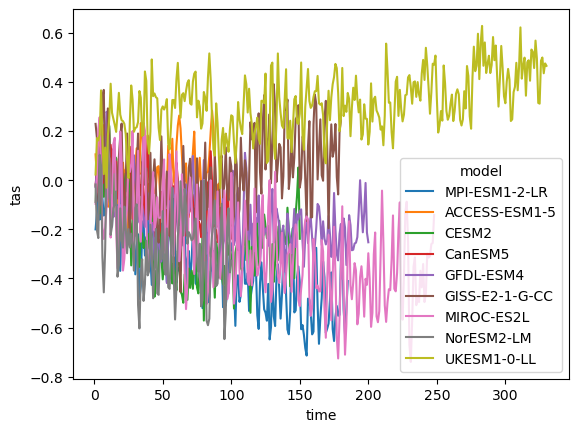

In [39]:
a1_smean_anom_ds.plot(hue='model');

## De-trending

In [40]:
# Detrend the data
a1_smean_anom_trendfit_ds = my_stats.trend_fit(a1_smean_anom_ds, method='polynomial', order=4)
a1_smean_anom_detrend_ds = a1_smean_anom_ds - a1_smean_anom_trendfit_ds

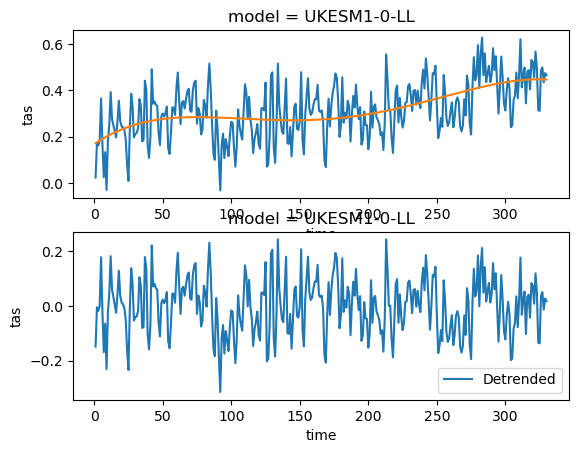

In [41]:
model = 'UKESM1-0-LL'#'CanESM5'#'CESM2'

fig, (ax1, ax2) = plt.subplots(2, 1)
a1_smean_anom_ds.sel(model=model).plot(ax=ax1, label='Raw')
a1_smean_anom_trendfit_ds.sel(model=model).plot(ax=ax1, label='Trend Fit')
a1_smean_anom_detrend_ds.sel(model=model).plot(ax=ax2, label='Detrended')
plt.legend()

## Single window checks S/N Ratio

In [42]:
reload(sn_calc)

<module 'signal_to_noise_calculations' from '/home/563/ab2313/Documents/zecmip_stabilisation/src/signal_to_noise_calculations.py'>

In [43]:
signal_rolling_ds, noise_rolling_ds, sn_ratio_test_rolling = sn_calc.signal_to_noise_ratio(
    a1_smean_anom_ds, 30, detrended_data=a1_smean_anom_detrend_ds, 
    noise_type='rolling', logginglevel='INFO', return_all=True)

- Calculating the rolling signal with method gradient
- noise_type='rolling'
- Calculting the rolling noise


In [44]:
signal_satatic_ds, noise_static_ds ,sn_ratio_test_static = sn_calc.signal_to_noise_ratio(
    a1_smean_anom_ds, 30, detrended_data=a1_smean_anom_detrend_ds
    , noise_type='static', logginglevel='INFO', return_all=True)

- Calculating the rolling signal with method gradient
- noise_type='static'
- Calculting the static noise


In [45]:
sn_calc.rolling_noise(a1_smean_anom_detrend_ds, 30)

<xarray.DataArray 'noise' (window: 1, model: 9, time: 300)> Size: 22kB
0.1055 0.1016 0.1002 0.1114 0.1163 ... 0.09008 0.0906 0.08831 0.08799 0.08723
Coordinates:
  * model    (model) <U14 504B 'MPI-ESM1-2-LR' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * time     (time) int64 2kB 1 2 3 4 5 6 7 8 ... 294 295 296 297 298 299 300
  * window   (window) int64 8B 30

In [46]:
sn_calc.static_noise(a1_smean_anom_detrend_ds)

<xarray.DataArray 'noise' (model: 9)> Size: 72B
0.1111 0.1068 0.09954 0.08833 0.1038 0.1412 0.1578 0.1539 0.1025
Coordinates:
  * model    (model) <U14 504B 'MPI-ESM1-2-LR' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'

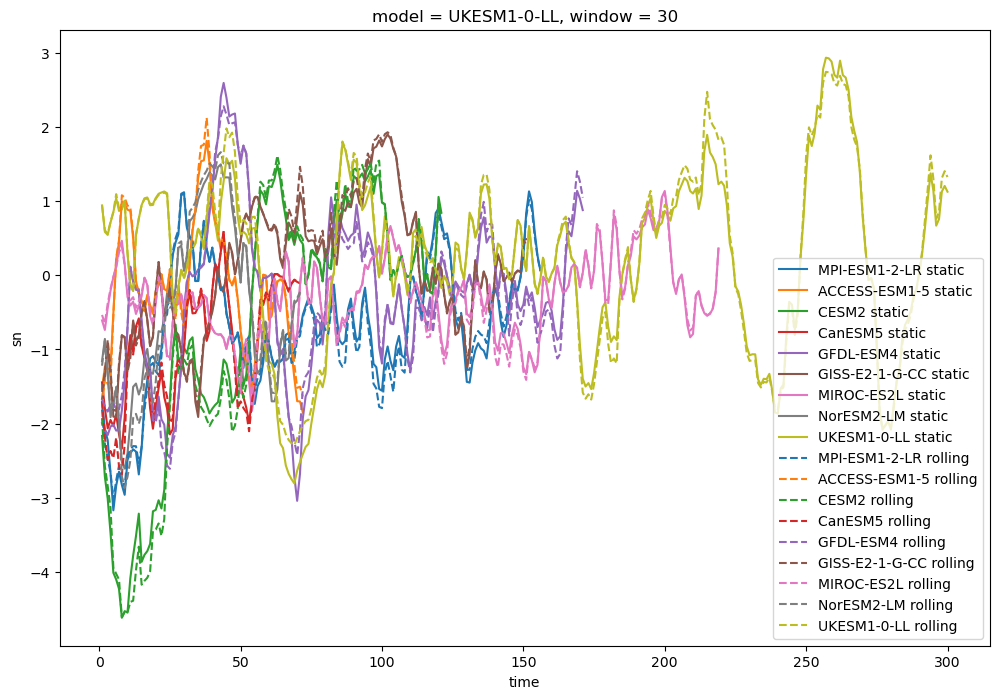

In [47]:
# Define a consistent color palette
models = sn_ratio_test_static.model.values
palette = sns.color_palette("tab10", n_colors=len(models))
color_dict = dict(zip(models, palette))

# Create the figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the first dataset
for model in models:
    sn_ratio_test_static.sel(model=model).plot(ax=ax, color=color_dict[model], label=f"{model} static")

# Plot the second dataset
for model in models:
    sn_ratio_test_rolling.sel(model=model).plot(ax=ax, color=color_dict[model], linestyle='--', label=f"{model} rolling")

# Add legend
ax.legend()

## Multi-window S/N Ratio

In [48]:
reload(sn_calc)

<module 'signal_to_noise_calculations' from '/home/563/ab2313/Documents/zecmip_stabilisation/src/signal_to_noise_calculations.py'>

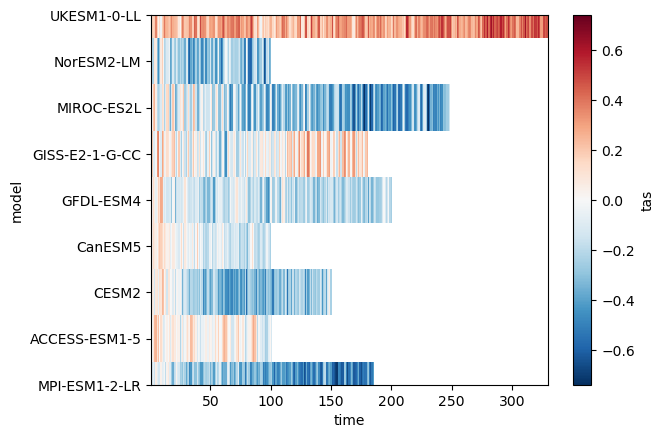

In [49]:
a1_smean_anom_ds.plot()

In [50]:
# Information about the length of availabile time in each model
# and the recomended maximum window length (the length of time - the minimum window (10))/10
# NOTE: This has been added to constants.
model_window_information = {}
for model in a1_smean_anom_ds.model.values:
    time_length = len(a1_smean_anom_ds.sel(model=model).dropna(dim='time').time.values)
    max_window = int(np.ceil((time_length-10)/3))
    model_window_information[model] = {'time_length':time_length, 'max_window':max_window}
model_window_information['UKESM1-0-LL']['max_window'] = 201

In [51]:
max_window = np.max(list(map(lambda info: info['max_window'], model_window_information.values())))
max_window

201

In [52]:
# windows = np.arange(10, max_window, 1)
windows = np.arange(10, 201)
#np.arange(**constants.ZECMIP_MULTI_WINDOW_PARAMS)
windows

array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 19

In [53]:
# Params to use for both
SN_PARAMS = dict(return_all=True, center=True, return_control=True, logginglevel='ERROR')

In [54]:
SN_RATIO_KWARGS = dict(parallel=True,logginglevel='ERROR')

In [55]:
reload(sn_calc)

<module 'signal_to_noise_calculations' from '/home/563/ab2313/Documents/zecmip_stabilisation/src/signal_to_noise_calculations.py'>

In [56]:
# # Calculate the S/R ratio for the A1 experiment. This noise should be the detrended data
sn_multi_static_da = sn_calc.signal_to_noise_ratio_multi_window(
    a1_smean_anom_ds,
    windows,
    detrended_data=a1_smean_anom_detrend_ds,
    start_align=False,
    noise_type='static',
    **SN_RATIO_KWARGS
)

In [57]:
# # Calculate the S/R ratio for the A1 experiment. This noise should be the detrended data
signal_multi_rolling_da = sn_calc.multi_window_func(
    sn_calc.rolling_signal,
    a1_smean_anom_ds,
    windows,
    start_align=False,
    # min_periods='half',
    **SN_RATIO_KWARGS
)

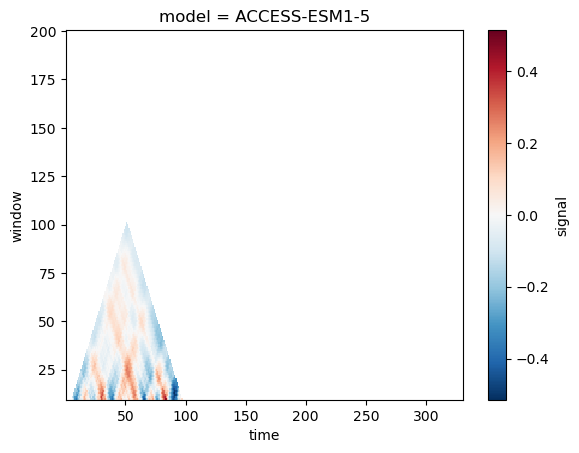

In [58]:
signal_multi_rolling_da.sel(model='ACCESS-ESM1-5').plot(y='window')

In [59]:
# # Calculate the S/R ratio for the A1 experiment. This noise should be the detrended data
noise_multi_rolling_da = sn_calc.multi_window_func(
    sn_calc.rolling_noise, a1_smean_anom_ds, windows, start_align=False,
    **SN_RATIO_KWARGS
)

In [60]:
# # Calculate the S/R ratio for the A1 experiment. This noise should be the detrended data
sn_multi_rolling_da = sn_calc.signal_to_noise_ratio_multi_window(
    a1_smean_anom_ds, windows,
    detrended_data=a1_smean_anom_detrend_ds,
    start_align=False,
    noise_type='rolling',
    # min_periods='half',
    **SN_RATIO_KWARGS
)

In [61]:
# # # Calculate the S/R ratio for the A1 experiment. This noise should be the detrended data
# sn_multi_rolling_ukesm_extra_da = sn_calc.signal_to_noise_ratio_multi_window(
#     a1_smean_anom_ds.sel(model='UKESM1-0-LL'), windows=np.arange(10, 201),
#     detrended_data=a1_smean_anom_detrend_ds.sel(model='UKESM1-0-LL'),
#     start_align=False,
#     noise_type='rolling',
#     # min_periods='half',
#     **SN_RATIO_KWARGS
# )

In [62]:
# sn_multi_rolling_control_ukesm_extra_da = sn_calc.signal_to_noise_ratio_multi_window(
#     esmpi_smean_ds.sel(model='UKESM1-0-LL'), np.arange(10, 201), noise_type='rolling', start_align=False, **SN_RATIO_KWARGS
# )

# sn_multi_rolling_control_ukesm_extra_da.name = 'signal_to_noise'

In [63]:
# bounds_ukesm_extra_da = sn_calc.upper_and_lower_bounds(sn_multi_rolling_control_ukesm_extra_da, 1, 99)
# bounds_ukesm_extra_da

In [64]:
# unstable_ukesm_extra_da = sn_multi_rolling_ukesm_extra_da.where(sn_multi_rolling_ukesm_extra_da>bounds_ukesm_extra_da.upper_bound)

In [65]:
# unstable_ukesm_extra_da.plot(y='window')

In [66]:
sn_multi_static_control_ds = sn_calc.signal_to_noise_ratio_multi_window(
    esmpi_smean_ds, windows, noise_type='static', start_align=False, **SN_RATIO_KWARGS
)

sn_multi_static_control_ds.name = 'signal_to_noise'

In [67]:
sn_multi_rolling_control_ds = sn_calc.signal_to_noise_ratio_multi_window(
    esmpi_smean_ds, windows, noise_type='rolling', start_align=False, **SN_RATIO_KWARGS
)

sn_multi_rolling_control_ds.name = 'signal_to_noise'

In [68]:
# sn_multi_rolling_ukesm_extra_da.plot(y='window')

In [69]:
# sn_multi_rolling_ukesm_extra_bounds = 

In [70]:
# The bounds from the pi-controls
rolling_bounds = sn_calc.upper_and_lower_bounds(sn_multi_rolling_control_ds, 1, 99)
static_bounds = sn_calc.upper_and_lower_bounds(sn_multi_static_control_ds, 1, 99)

In [71]:
sn_multi_rolling_da

<xarray.DataArray 'sn' (window: 191, model: 9, time: 330)> Size: 5MB
nan nan nan nan nan 1.209 0.6404 0.5739 ... nan nan nan nan nan nan nan nan
Coordinates:
  * model    (model) <U14 504B 'MPI-ESM1-2-LR' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * time     (time) int64 3kB 1 2 3 4 5 6 7 8 ... 324 325 326 327 328 329 330
  * window   (window) int64 2kB 10 11 12 13 14 15 16 ... 195 196 197 198 199 200

In [72]:
# Mergine togeth with the bounds (more of a legacy need)
# Drop nan here, or some windows can be longer than others
sn_multi_static_ds = xr.merge([sn_multi_static_da.to_dataset(), static_bounds])
sn_multi_rolling_ds = xr.merge([sn_multi_rolling_da.to_dataset(), rolling_bounds])

In [73]:
sn_multi_rolling_da

<xarray.DataArray 'sn' (window: 191, model: 9, time: 330)> Size: 5MB
nan nan nan nan nan 1.209 0.6404 0.5739 ... nan nan nan nan nan nan nan nan
Coordinates:
  * model    (model) <U14 504B 'MPI-ESM1-2-LR' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * time     (time) int64 3kB 1 2 3 4 5 6 7 8 ... 324 325 326 327 328 329 330
  * window   (window) int64 2kB 10 11 12 13 14 15 16 ... 195 196 197 198 199 200

In [74]:
# # # Number of models stable at each time step.
# rolling_stability_levels_ds = sn_calc.get_increase_and_decreasing_stability_number(sn_multi_rolling_ds)
# static_stability_levels_ds = sn_calc.get_increase_and_decreasing_stability_number(sn_multi_static_ds)

In [75]:
sn_multi_rolling_ds

<xarray.Dataset> Size: 5MB
Dimensions:      (model: 9, time: 330, window: 191)
Coordinates:
  * model        (model) <U14 504B 'MPI-ESM1-2-LR' ... 'UKESM1-0-LL'
  * time         (time) int64 3kB 1 2 3 4 5 6 7 ... 324 325 326 327 328 329 330
  * window       (window) int64 2kB 10 11 12 13 14 15 ... 196 197 198 199 200
Data variables:
    sn           (window, model, time) float64 5MB nan nan nan ... nan nan nan
    lower_bound  (window, model) float64 14kB -2.95 -2.997 ... -1.156 -2.063
    upper_bound  (window, model) float64 14kB 2.975 2.981 2.95 ... 1.226 1.641

In [76]:
# Just the unstalgbe points - both xrlist and ds
above_or_below_kwargs = dict(main_var='sn', greater_than_var='upper_bound', less_than_var='lower_bound')

unstable_rolling_ds = sn_multi_rolling_ds.utils.above_or_below(**above_or_below_kwargs)
unstable_static_ds = sn_multi_static_ds.utils.above_or_below(**above_or_below_kwargs)

In [77]:
# For each window get the number of years that are stable forn each point in time
# Note, these are nnot used much. 
decreasing_ds = xr.where(unstable_rolling_ds < 0, 1, 0)
increasing_ds = xr.where(unstable_rolling_ds > 0, 1, 0)

## Get year of stabilisation

## Original

In [78]:
ufunc_year_stabilisation_kwargs = dict(
    input_core_dims=[['time'], []],
    output_core_dims=[[]],
    vectorize=True,
    output_dtypes=[np.float64]
)

In [79]:
# Get the year that stabilisation occurs
static_year_stable_ds_original = xr.apply_ufunc(
    sn_calc.find_stability_index,
    unstable_static_ds.sn.squeeze(),
    unstable_static_ds.window,
    **ufunc_year_stabilisation_kwargs
)

In [80]:
# Get the year that stabilisation occurs
rolling_year_stable_ds_original  = xr.apply_ufunc(
    sn_calc.find_stability_index,
    unstable_rolling_ds.sn.squeeze(),
    unstable_rolling_ds.window,
    **ufunc_year_stabilisation_kwargs
)

# De-stabilisatin Detection

In [81]:
windows = unstable_rolling_ds.window.values
windows

array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 19

In [173]:
# year_stable_and_unstable_static_ds = xr.apply_ufunc(
#     partial(sn_calc.calcuate_year_stable_and_unstable, windows=windows),
#     unstable_static_ds.transpose(*['time', 'window', 'model']).sn,
#     input_core_dims=[['time', 'window']],
#     output_core_dims=[['stability_index']],
#     dask_gufunc_kwargs={'output_sizes': {'stability_index': 9}},
#     vectorize=True,
#     kwargs={'max_val': 300, 'number_attempts':9, 'logginglevel':'ERROR'}
# )
# year_stable_and_unstable_static_ds=year_stable_and_unstable_static_ds.assign_coords(
#     stability_index=[1, 2, 3, 4, 5, 6, 7, 8, 9])

# year_stable_and_unstable_static_ds.attrs['Stability index'] ='Odd values mean stable, even mean unstable'

In [454]:
# ### The year stable and unstalbe not must be done seperatly per model, 
# ### this is becuase the windows is now different depending on the model.
# number_attempts = 9

# year_stable_and_unstable_model_list = []
# for model in unstable_rolling_ds.model.values:
#     unstable_rolling_ds_model = unstable_rolling_ds.sel(model=model)
#     unstable_rolling_ds_model = unstable_rolling_ds_model.sel(
#         window=slice(None, model_window_information[model]['max_window']))
#     model_windows = unstable_rolling_ds_model.window.values

#     max_val = model_window_information[model]['time_length']- 11
#     print(model,model_windows)
    
#     year_stable_and_unstable_model_ds = xr.apply_ufunc(
#         sn_calc.calcuate_year_stable_and_unstable,
#         unstable_rolling_ds_model.transpose(*['time', 'window']).sn,
#         input_core_dims=[['time', 'window']],
#         output_core_dims=[['stability_index']],
#         dask_gufunc_kwargs={'output_sizes': {'stability_index': number_attempts}},
#         vectorize=True,
#         kwargs={'max_val': max_val, 'windows':model_windows, 'period_length': 10,
#                 'number_attempts':number_attempts, 'logginglevel':'ERROR'}
#     )
#     year_stable_and_unstable_model_ds=year_stable_and_unstable_model_ds.assign_coords(
#         stability_index=np.arange(1, number_attempts+1))
    
#     year_stable_and_unstable_model_ds.attrs['Stability index'] ='Odd values mean stable, even mean unstable'

#     year_stable_and_unstable_model_list.append(year_stable_and_unstable_model_ds)

# year_stable_and_unstable_rolling_ds = xr.concat(year_stable_and_unstable_model_list, dim='model')

MPI-ESM1-2-LR [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59]
ACCESS-ESM1-5 [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
CESM2 [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
CanESM5 [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
GFDL-ESM4 [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64]


AssertionError: The point query year is less than 0

In [161]:
# All the stable periods that are less than 7 should be deleted here.
# Stable 4, unstable 8, stable 23, unstable 33, 
# What should remain is 
# [8, 23, 33, 42, 64]
# year_vals = [4., 8,  23.,  33.,  37.,  42.,  59.,  64.]


# Stable only between year 10 and 13
# Stable between year 30 and 40
# Stable between year 60 and 64
# To Return [30, 40]
# year_vals = [10, 13, 30, 40, 60, 64]

# year_vals = np.delete(year_vals, small_stable_period_args*2)
# year_vals = np.delete(year_vals, small_stable_period_args*2)

In [120]:
# This didn't work as the unstable_sn_data is float not binary
# unstable_frac_da = xr.apply_ufunc(
#     sn_calc.frac_non_zero,
#     unstable_rolling_ds.sn, 
#     input_core_dims=[['time']],
#     output_core_dims=[['time']],
#     vectorize=True,
#     kwargs = {'period_length': 10}
# )

In [140]:
model = 'MPI-ESM1-2-LR'#'ACCESS-ESM1-5'#'GISS-E2-1-G-CC'#'GFDL-ESM4'#
unstable_rolling_ds_model = unstable_rolling_ds.sel(model=model)
unstable_rolling_ds_model = unstable_rolling_ds_model.sel(
    window=slice(None, model_window_information[model]['max_window']))
model_windows = unstable_rolling_ds_model.window.values

unstable_rolling_ds_model = xr.where(np.isfinite(unstable_rolling_ds_model), 1, 0).sn

max_val = model_window_information[model]['time_length']- 11
print(model,model_windows)

MPI-ESM1-2-LR [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59]


In [141]:
unstable_frac_model_da = xr.apply_ufunc(
    sn_calc.frac_non_zero,
    unstable_rolling_ds_model, 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    kwargs = {'period_length': 10}
)

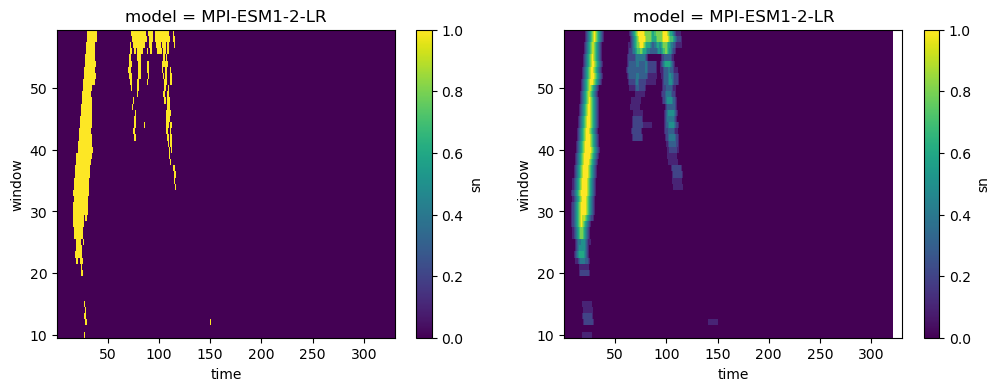

In [142]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))
unstable_rolling_ds_model.plot(y='window', ax=ax1)
unstable_frac_model_da.plot(y='window', ax=ax2)

In [209]:
number_attempts = 9

year_stable_and_unstable_model_ds = xr.apply_ufunc(
    sn_calc.calcuate_year_stable_and_unstable,
    unstable_rolling_ds_model.transpose(*['time', 'window']),
    unstable_frac_model_da.transpose(*['time', 'window']),
    input_core_dims=[['time', 'window'], ['time', 'window']],
    output_core_dims=[['stability_index']],
    dask_gufunc_kwargs={'output_sizes': {'stability_index': number_attempts}},
    vectorize=True,
    kwargs={'max_val': max_val, 'windows':model_windows, 'period_length': 20,
            'number_attempts':number_attempts, 'logginglevel':'DEBUG'}
)

- period_length=20
- Shapes - time_window_arr = (330, 191), frac_unstable_arr = (330, 191)
- initial_fracs shape (20, 191)
-  - inital_fracs (shape = (20, 191))
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0

In [210]:
year_stable_and_unstable_model_ds

<xarray.DataArray 'sn' (stability_index: 9)> Size: 72B
0.0 184.0 241.0 270.0 281.0 nan nan nan nan
Coordinates:
    model    <U14 56B 'UKESM1-0-LL'
Dimensions without coordinates: stability_index

In [211]:
## The year stable and unstalbe not must be done seperatly per model, 
### this is becuase the windows is now different depending on the model.
number_attempts = 9
period_length = 10

year_stable_and_unstable_model_list = []
for model in unstable_rolling_ds.model.values:
    unstable_rolling_ds_model = unstable_rolling_ds.sel(model=model).sel(
        window=slice(None, model_window_information[model]['max_window'])).sn

    unstable_rolling_ds_model = xr.where(np.isfinite(unstable_rolling_ds_model), 1, 0)
    # unstable_frac_model_da = unstable_frac_da.sel(model=model).sel(
    #     window=slice(None, model_window_information[model]['max_window']))

    unstable_frac_model_da = xr.apply_ufunc(
        sn_calc.frac_non_zero,
        unstable_rolling_ds_model, 
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        kwargs = {'period_length': period_length}
    )
    
    model_windows = unstable_rolling_ds_model.window.values


    max_val = model_window_information[model]['time_length']- 11
    print(model,model_windows)
    
    year_stable_and_unstable_model_ds = xr.apply_ufunc(
        sn_calc.calcuate_year_stable_and_unstable,
        unstable_rolling_ds_model.transpose(*['time', 'window']),
        unstable_frac_model_da.transpose(*['time', 'window']),
        input_core_dims=[['time', 'window'], ['time', 'window']],
        output_core_dims=[['stability_index']],
        dask_gufunc_kwargs={'output_sizes': {'stability_index': number_attempts}},
        vectorize=True,
        kwargs={'max_val': max_val, 'windows':model_windows, 'period_length': period_length,
                'number_attempts':number_attempts, 'logginglevel':'ERROR'}
    )
    year_stable_and_unstable_model_ds=year_stable_and_unstable_model_ds.assign_coords(
        stability_index=np.arange(1, number_attempts+1))
    
    year_stable_and_unstable_model_ds.attrs['Stability index'] ='Odd values mean stable, even mean unstable'

    year_stable_and_unstable_model_list.append(year_stable_and_unstable_model_ds)

year_stable_and_unstable_rolling_ds = xr.concat(year_stable_and_unstable_model_list, dim='model')

MPI-ESM1-2-LR [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59]
ACCESS-ESM1-5 [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
CESM2 [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
CanESM5 [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
GFDL-ESM4 [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64]
GISS-E2-1-G-CC [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57]
MIROC-ES2L [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 7

In [212]:
year_stable_and_unstable_rolling_ds

<xarray.DataArray 'sn' (model: 9, stability_index: 9)> Size: 648B
0.0 17.0 40.0 73.0 116.0 nan nan nan ... 184.0 241.0 270.0 281.0 nan nan nan nan
Coordinates:
  * model            (model) <U14 504B 'MPI-ESM1-2-LR' ... 'UKESM1-0-LL'
  * stability_index  (stability_index) int64 72B 1 2 3 4 5 6 7 8 9
Attributes:
    Stability index:  Odd values mean stable, even mean unstable

In [213]:
sn_rolling_nan_locs = np.isnan(sn_multi_rolling_da)

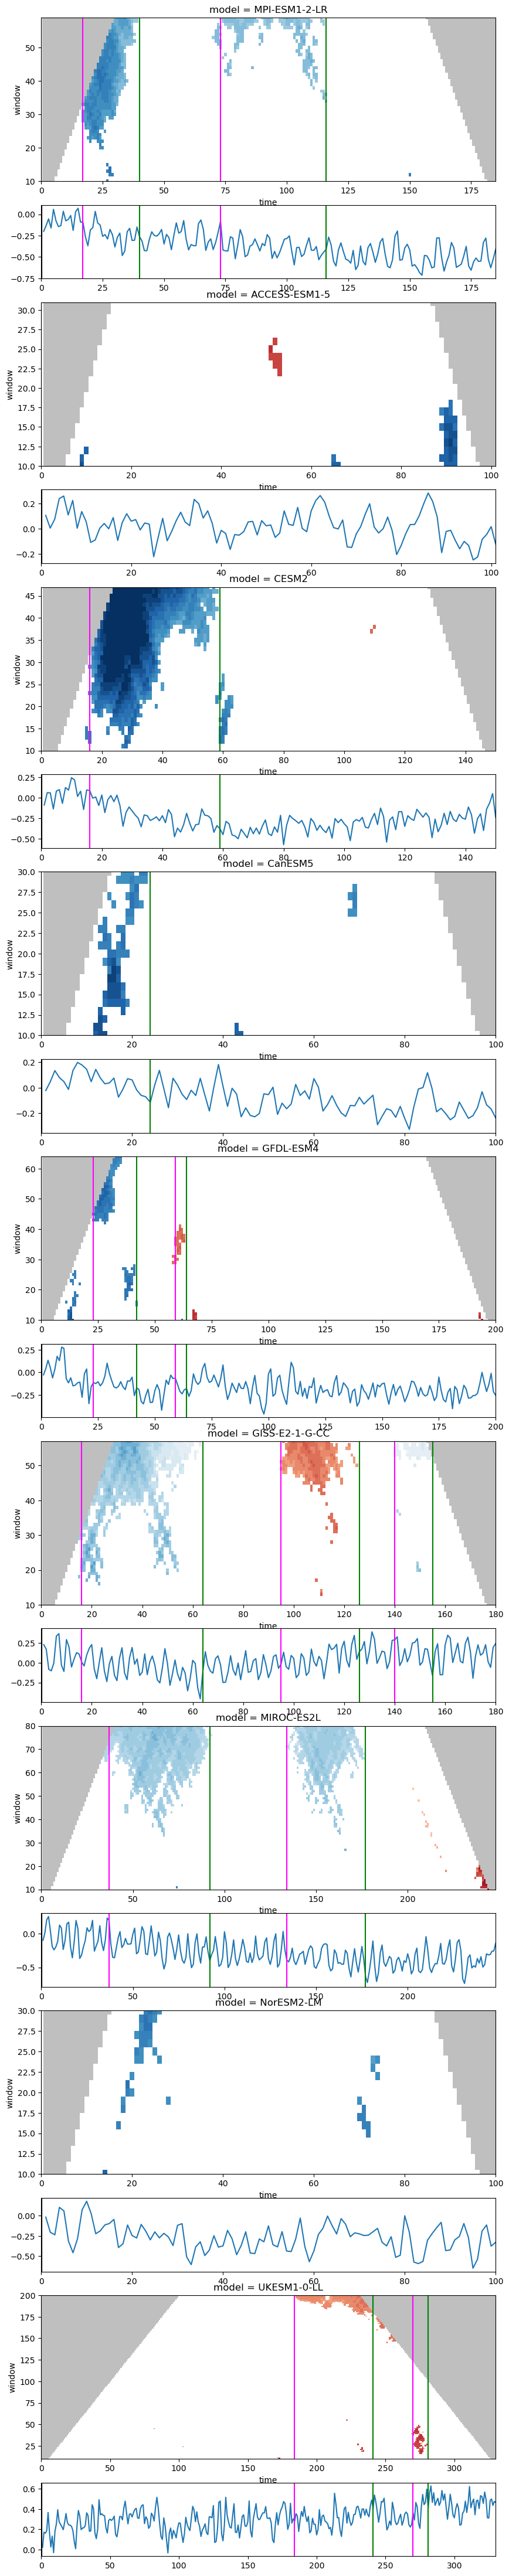

In [214]:
fig = plt.figure(figsize=(10, 45*1.25))
gs = gridspec.GridSpec(18,1, height_ratios=[1, 0.45]*9)
axes = [fig.add_subplot(gs[i]) for i in range(18)]

colors = ['green', 'magenta']
for mnum, num in enumerate(np.arange(0, 18, 2)):
    ax = axes[num]
    ax2 = axes[num+1]
    model = models[mnum]
    
    unstable_rolling_ds.sel(model=model).sn.plot(
        y='window', ax=ax, cmap='RdBu_r', levels=np.arange(-4, 4.25, .25), add_colorbar=False)

    sn_plotting.grey_mask(ax,sn_rolling_nan_locs.sel(model=model))
    
    a1_model_ds = a1_smean_anom_ds.sel(model=model)
    ax2.plot(a1_model_ds.time.values, a1_model_ds.values)
    for num,year in enumerate(year_stable_and_unstable_rolling_ds.sel(model=model).values):
        ax.axvline(year, c=colors[num%2])
        ax2.axvline(year, c=colors[num%2])

    # ax.axvspan(model_max_vals[model]-half_window, model_max_vals[model], color='grey')
    # ax.axvspan(-half_window, 0, color='grey')
    ax2.axvline(0, color='k', linewidth=3)
    

    ax.set_xlim(0,model_window_information[model]['time_length'])
    ax2.set_xlim(0,model_window_information[model]['time_length'])
    ax.set_ylim(10, model_window_information[model]['max_window'] if 'UKESM' not in model else 200)

## Processing

In [215]:
# static_year_stable_ds = year_stable_and_unstable_static_ds.sel(stability_index=1) #total_stable_year_da_static
rolling_year_stable_ds = year_stable_and_unstable_rolling_ds.sel(stability_index=1) #total_stable_year_da_rolling

In [216]:
# static_year_stable_ds=static_year_stable_ds.to_dataset(name='time')
rolling_year_stable_ds=rolling_year_stable_ds.to_dataset(name='time')

In [217]:
rolling_year_stable_ds

<xarray.Dataset> Size: 584B
Dimensions:          (model: 9)
Coordinates:
  * model            (model) <U14 504B 'MPI-ESM1-2-LR' ... 'UKESM1-0-LL'
    stability_index  int64 8B 1
Data variables:
    time             (model) float64 72B 0.0 0.0 0.0 24.0 0.0 0.0 0.0 0.0 0.0

# Tabulated

In [218]:
year_stable_and_unstable_rolling_ds.stability_index.values[::2]

array([1, 3, 5, 7, 9])

In [423]:
utils.change_logginglevel('ERROR')

# Initialize an empty dictionary to store results
year_of_stabilisation_dict = {}

# Iterate over each model in the dataset
for model in year_stable_and_unstable_rolling_ds.model.values:
    model_dict = {}  # Dictionary to store results for the current model
    
    # Retrieve and store the 'zec50' value for the model
    zec50_val = zec50_ds.sel(model=model).values.item()
    model_dict['zec50'] = zec50_val
    
    # Retrieve year values for the current model
    year_vals = year_stable_and_unstable_rolling_ds.sel(model=model).values
    
    a1_smean_model_ds = a1_smean_anom_ds.sel(model=model).dropna(dim='time')
    # Process each year value
    logger.info(year_vals)
    for i in range(len(year_vals)):
        
        yeari = year_vals[i]
        logger.info(f'\n{i=}')
        if np.isnan(yeari):
            avtemp = np.nan
            break
       
        else:
            yeari = int(yeari)
            # The even values are the stablre periods
            if not i%2:
                logger.info('Stable Temp')
                # We want to take the average of the whole stable period
                end_point = year_vals[i + 1]
                logger.debug(f'{end_point=}')
                if np.isnan(end_point):
                    end_point =  len(a1_smean_model_ds.time.values)
                end_point = int(end_point)
                logger.debug(f'{yeari=}, {end_point=}')
                temp = a1_smean_model_ds.isel(time=slice(yeari, end_point)
                                             ).mean(dim='time').values.round(2).item()
                logger.debug(f'{temp=}')

            # We want to get the change in the temperature from the 
            # period that is either twenty year of the entire stable period before hand
            else:
                logger.info('Unstable Temp')
                unstable_start_year = yeari
                unstable_finsh_year = int(year_vals[i+1])
                previous_stable_start = int(year_vals[i-1])
                next_stable_start = year_vals[i+2]
                if np.isnan(next_stable_start):
                    next_stable_start = len(a1_smean_model_ds.time.values)
                next_stable_start = int(next_stable_start)

                logger.debug(f'{unstable_start_year=}, {unstable_finsh_year=}, {previous_stable_start=}, {next_stable_start=}')
                    
                                     
                                     
                before_length = np.nanmin([unstable_start_year - previous_stable_start, 20])
                after_length = np.nanmin([next_stable_start-unstable_finsh_year, 20]) 
                
                before_temp = a1_smean_model_ds.isel(
                    time=slice(unstable_start_year-before_length, unstable_start_year)
                ).mean(dim='time').values.item()
                
                after_temp = a1_smean_model_ds.isel(
                    time=slice(unstable_finsh_year, unstable_finsh_year+after_length)
                ).mean(dim='time').values.item()
                
                temp = after_temp - before_temp
                
            
        
        # Determine the stability label (stable or unstable)
        if not i%2:
            label = f'stable_period_temp_av_{i}'
            stype = 'stable'
            
        else:
            label = f'unstable_period_temp_change_{i}'
            stype = 'unstable'
        # label = 'unstable' if i % 2 else 'stable'
        
        
        # Store year and average temperature in the model dictionary
        model_dict[f'{stype}_{i}'] = yeari
        model_dict[label] = temp
        
        # Store the final zec50 value after adjustment and final temperature
        model_dict['zec50-final'] = np.round(zec50_val - temp, 2)
        model_dict['final_temp'] = temp
        
        # Store the maximum stability index value for the model
        model_dict['final_year_stable'] = (year_stable_and_unstable_rolling_ds
                                           .sel(stability_index=year_stable_and_unstable_rolling_ds.stability_index.values[::2], model=model)
                                           .max(dim='stability_index')).values

    # Add the model dictionary to the main dictionary
    year_of_stabilisation_dict[model] = model_dict

# Convert the dictionary to a DataFrame and transpose it
year_of_stabilisation_df = pd.DataFrame(year_of_stabilisation_dict).transpose()

# Drop columns with all NaN values
year_of_stabilisation_df = year_of_stabilisation_df.dropna(axis=1, how='all')

# Define the desired order of columns
order_start = ['zec50', 'final_temp', 'zec50-final', 'final_year_stable']

# Reorder columns and round values to 2 decimal places
year_of_stabilisation_df = year_of_stabilisation_df[order_start + [col for col in year_of_stabilisation_df.columns if col not in order_start]]
year_of_stabilisation_df = year_of_stabilisation_df.round(2)

# Set the index name of the DataFrame to 'model'
year_of_stabilisation_df.index.name = 'model'


In [424]:
year_of_stabilisation_df

zec50 final_temp zec50-final final_year_stable stable_0  \
model                                                                        
MPI-ESM1-2-LR  -0.270157      -0.49        0.22             116.0        0   
ACCESS-ESM1-5   0.011302       0.02       -0.01               0.0        0   
CESM2          -0.309638      -0.31         0.0              59.0        0   
CanESM5         -0.10173      -0.11        0.01              24.0       24   
GFDL-ESM4       -0.20539      -0.19       -0.02              64.0        0   
GISS-E2-1-G-CC -0.090083       0.12       -0.21             155.0        0   
MIROC-ES2L     -0.108559       -0.4        0.29             177.0        0   
NorESM2-LM      -0.33444      -0.27       -0.06               0.0        0   
UKESM1-0-LL     0.289383       0.45       -0.16             281.0        0   

               stable_period_temp_av_0 unstable_1  \
model                                               
MPI-ESM1-2-LR                    -0.07         17   
ACCESS-ESM1-5                     0.02        NaN   
CESM2                             0.05         16   
CanESM5                          -0.11        NaN   
GFDL-ESM4                        -0.03         23   
GISS-E2-1-G-CC                    0.09         16   
MIROC-ES2L                       -0.04         37   
NorESM2-LM                       -0.27        NaN   
UKESM1-0-LL                       0.27        184   

               unstable_period_temp_change_1 stable_2 stable_period_temp_av_2  \
model                                                                           
MPI-ESM1-2-LR                      -0.197643       40                   -0.27   
ACCESS-ESM1-5                            NaN      NaN                     NaN   
CESM2                              -0.446907       59                   -0.31   
CanESM5                                  NaN      NaN                     NaN   
GFDL-ESM4                          -0.170662       42                   -0.21   
GISS-E2-1-G-CC                     -0.148824       64                   -0.05   
MIROC-ES2L                         -0.241244       92                   -0.28   
NorESM2-LM                               NaN      NaN                     NaN   
UKESM1-0-LL                         0.048524      241                    0.34   

               unstable_3 unstable_period_temp_change_3 stable_4  \
model                                                              
MPI-ESM1-2-LR          73                     -0.222876      116   
ACCESS-ESM1-5         NaN                           NaN      NaN   
CESM2                 NaN                           NaN      NaN   
CanESM5               NaN                           NaN      NaN   
GFDL-ESM4              59                      0.107634       64   
GISS-E2-1-G-CC         95                       0.19885      126   
MIROC-ES2L            134                      -0.17245      177   
NorESM2-LM            NaN                           NaN      NaN   
UKESM1-0-LL           270                      0.171212      281   

               stable_period_temp_av_4 unstable_5  \
model                                               
MPI-ESM1-2-LR                    -0.49        NaN   
ACCESS-ESM1-5                      NaN        NaN   
CESM2                              NaN        NaN   
CanESM5                            NaN        NaN   
GFDL-ESM4                        -0.19        NaN   
GISS-E2-1-G-CC                    0.15        140   
MIROC-ES2L                        -0.4        NaN   
NorESM2-LM                         NaN        NaN   
UKESM1-0-LL                       0.45        NaN   

               unstable_period_temp_change_5 stable_6 stable_period_temp_av_6  
model                                                                          
MPI-ESM1-2-LR                            NaN      NaN                     NaN  
ACCESS-ESM1-5                            NaN      NaN                     NaN  
CESM2                          

In [400]:
# # Initialize an empty dictionary to store results
# year_of_stabilisation_dict = {}

# # Iterate over each model in the dataset
# for model in year_stable_and_unstable_rolling_ds.model.values:
#     model_dict = {}  # Dictionary to store results for the current model
    
#     # Retrieve and store the 'zec50' value for the model
#     zec50_val = zec50_ds.sel(model=model).values.item()
#     model_dict['zec50'] = zec50_val
    
#     # Retrieve year values for the current model
#     year_vals = year_stable_and_unstable_rolling_ds.sel(model=model).values
    
#     # Process each year value
#     for i in range(len(year_vals)):
#         yeari = year_vals[i]
        
#         if np.isnan(yeari):
#             avtemp = np.nan
#             break
#         else:
#             # Determine the length for the average temperature calculation
 
#             if i + 1 == len(year_stable_and_unstable_rolling_ds.stability_index.values):
#                 length = 20
#             else:
#                 length = np.nanmin([20, year_vals[i + 1]])
            
#             yeari = int(yeari)
#             length = int(length)
            
#             # Calculate the average temperature for the given year range
#             avtemp = (a1_smean_anom_ds.sel(model=model)
#                       .isel(time=slice(yeari, yeari + length))
#                       .mean(dim='time').values.round(2).item())
        
#         # Determine the stability label (stable or unstable)
#         label = 'unstable' if i % 2 else 'stable'
        
#         # Store year and average temperature in the model dictionary
#         model_dict[f'{label}_{i + 1}_year'] = yeari
#         model_dict[f'{label}_{i + 1}_avtemp'] = avtemp
        
#         # Store the final zec50 value after adjustment and final temperature
#         model_dict['zec50-final'] = np.round(zec50_val - avtemp, 2)
#         model_dict['final_temp'] = avtemp
        
#         # Store the maximum stability index value for the model
#         model_dict['final_year_stable'] = (year_stable_and_unstable_rolling_ds
#                                            .sel(stability_index=year_stable_and_unstable_rolling_ds.stability_index.values[::2], model=model)
#                                            .max(dim='stability_index')).values

#     # Add the model dictionary to the main dictionary
#     year_of_stabilisation_dict[model] = model_dict

# # Convert the dictionary to a DataFrame and transpose it
# year_of_stabilisation_df = pd.DataFrame(year_of_stabilisation_dict).transpose()

# # Drop columns with all NaN values
# year_of_stabilisation_df = year_of_stabilisation_df.dropna(axis=1, how='all')

# # Define the desired order of columns
# order_start = ['zec50', 'final_temp', 'zec50-final', 'final_year_stable']

# # Reorder columns and round values to 2 decimal places
# year_of_stabilisation_df = year_of_stabilisation_df[order_start + [col for col in year_of_stabilisation_df.columns if col not in order_start]]
# year_of_stabilisation_df = year_of_stabilisation_df.round(2)

# # Set the index name of the DataFrame to 'model'
# year_of_stabilisation_df.index.name = 'model'


In [401]:
# year_of_stabilisation_df

In [402]:
DATA_DIR = os.getcwd() + '/Documents/zecmip_stabilisation/data'
os.path.join(DATA_DIR, 'model_gsmt_stabilisation.csv')
year_of_stabilisation_df.to_csv(os.path.join(DATA_DIR, 'model_gsmt_stabilisation_v2.csv'))

In [403]:
print(year_of_stabilisation_df[['final_year_stable', 'final_temp', 'zec50',  'zec50-final']])

               final_year_stable final_temp     zec50 zec50-final
model                                                            
MPI-ESM1-2-LR              116.0      -0.49 -0.270157        0.22
ACCESS-ESM1-5                0.0       0.02  0.011302       -0.01
CESM2                       59.0      -0.31 -0.309638         0.0
CanESM5                     24.0      -0.11  -0.10173        0.01
GFDL-ESM4                   64.0      -0.19  -0.20539       -0.02
GISS-E2-1-G-CC             155.0       0.12 -0.090083       -0.21
MIROC-ES2L                 177.0       -0.4 -0.108559        0.29
NorESM2-LM                   0.0      -0.27  -0.33444       -0.06
UKESM1-0-LL                281.0       0.45  0.289383       -0.16


In [404]:
cooling_models = ['MPI-ESM1-2-LR', 'CESM2', 'CanESM5', 'GFDL-ESM4', 'GISS-E2-1-G-CC', 'NorESM2-LM']

In [406]:
year_of_stabilisation_df.loc[cooling_models].mean(axis=0)

zec50                            -0.218573
final_temp                       -0.208333
zec50-final                          -0.01
final_year_stable                69.666667
stable_0                               4.0
stable_period_temp_av_0          -0.056667
unstable_1                            18.0
unstable_period_temp_change_1          0.0
stable_2                             51.25
stable_period_temp_av_2              -0.21
unstable_3                       75.666667
unstable_period_temp_change_3          0.0
stable_4                             102.0
stable_period_temp_av_4          -0.176667
unstable_5                           140.0
unstable_period_temp_change_5          0.0
stable_6                             155.0
stable_period_temp_av_6               0.12
dtype: object

In [225]:
year_of_stabilisation_df.mean(axis=0)

zec50                -0.124368
final_temp           -0.103333
zec50-final          -0.021111
final_year_stable    97.333333
stable_1_year         2.666667
stable_1_avtemp       0.015556
unstable_2_year      48.833333
unstable_2_avtemp        -0.06
stable_3_year        89.666667
stable_3_avtemp      -0.143333
unstable_4_year          126.2
unstable_4_avtemp        -0.07
stable_5_year            152.8
stable_5_avtemp         -0.082
unstable_6_year          140.0
unstable_6_avtemp         0.09
stable_7_year            155.0
stable_7_avtemp           0.12
dtype: object

# Quick Verifications

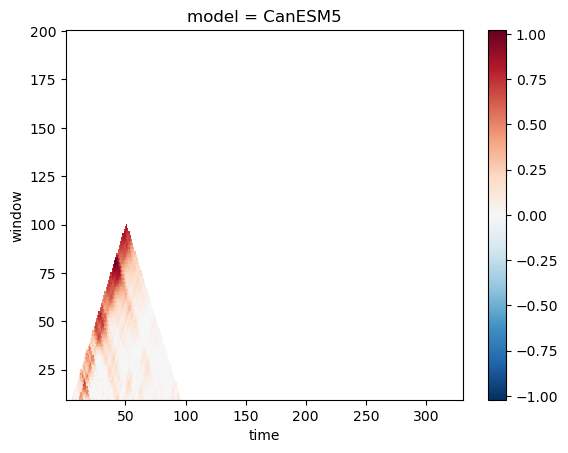

In [226]:
((signal_multi_rolling_da/noise_multi_rolling_da).isel(model=3)-sn_multi_rolling_da.isel(model=3)).plot()

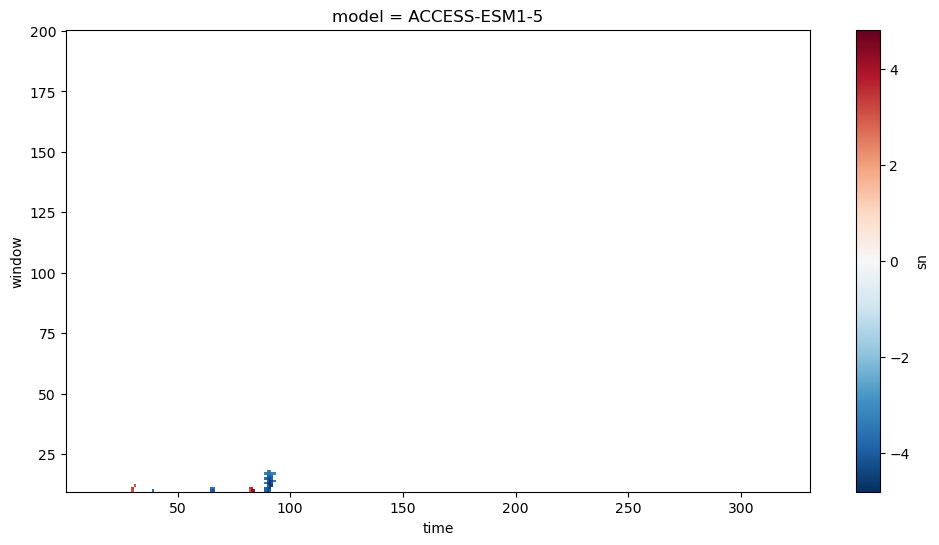

In [227]:
imodel = 1
fig = plt.figure(figsize=(12, 6))
unstable_static_ds.isel(model=imodel).sn.plot(y='window')
# static_year_stable_ds.time.isel(model=imodel).plot(y='window', marker='o', color='red')

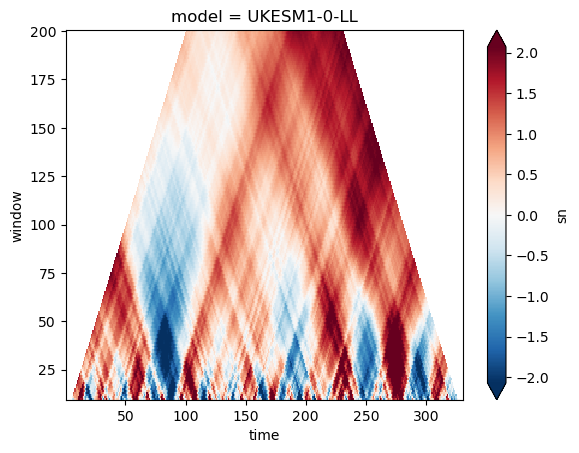

In [228]:
sn_multi_rolling_ds.sel(model='UKESM1-0-LL').sn.plot(robust=True)

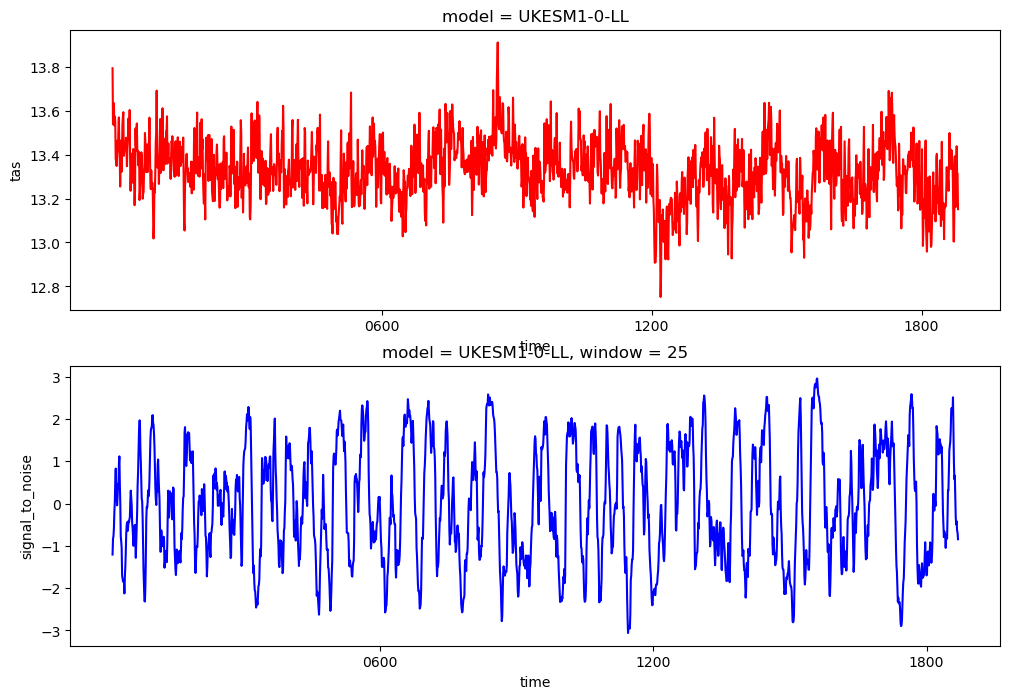

In [229]:
fig, (ax, ax2) = plt.subplots(2, 1,figsize=(12, 8))
# ax2 = ax.twinx()
esmpi_smean_ds.sel(model='UKESM1-0-LL').plot(ax=ax, color='red')
sn_multi_rolling_control_ds.sel(model='UKESM1-0-LL', window=25).plot(ax=ax2, color='blue')

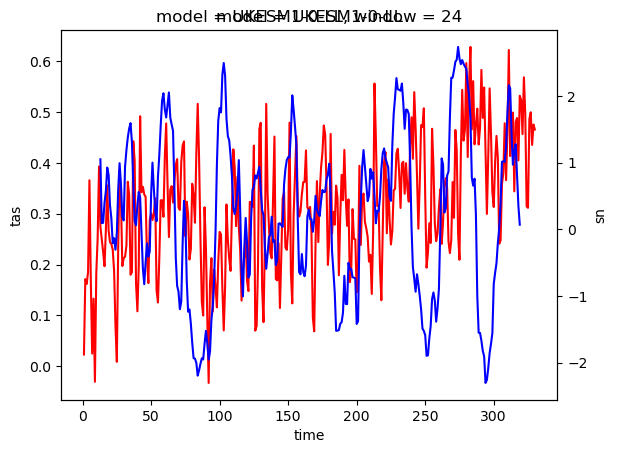

In [230]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
a1_smean_anom_ds.sel(model='UKESM1-0-LL').plot(ax=ax, color='red')
sn_multi_rolling_ds.sn.sel(model='UKESM1-0-LL', window=24).plot(ax=ax2, color='blue')

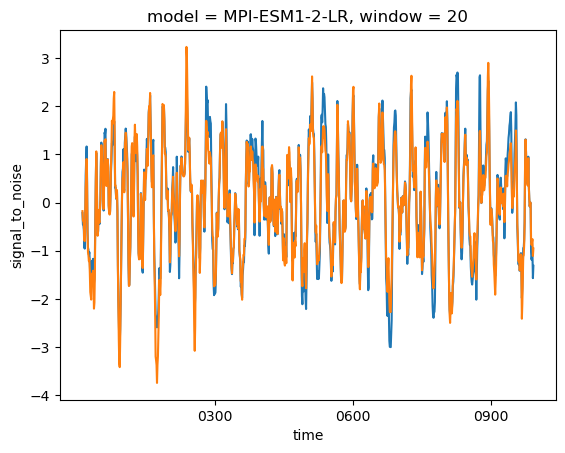

In [231]:
sn_multi_rolling_control_ds.isel(model=0, window=10).plot()
sn_multi_static_control_ds.isel(model=0, window=10).plot()

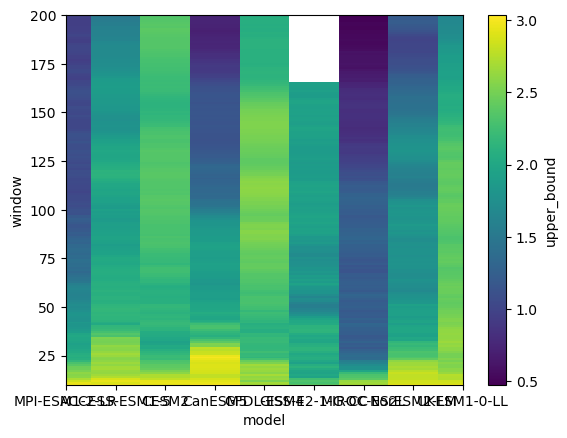

In [232]:
rolling_bounds.upper_bound.plot()

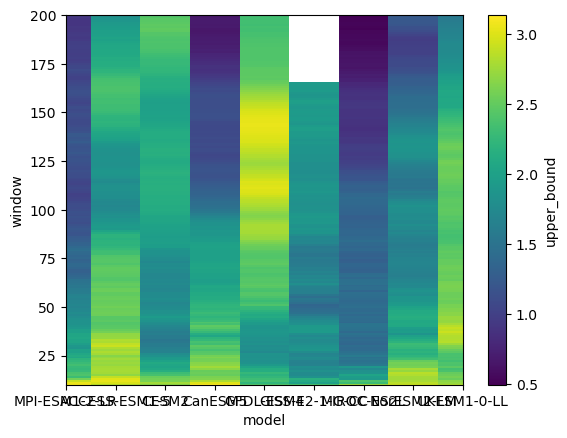

In [233]:
static_bounds.upper_bound.plot()

# Plots

## Set-up

In [234]:
units =  r'$^{\circ}C$'

In [235]:
def format_null_axis(ax):
    '''
    Axis that doesn't have any spines, or y tick labels or locaionts
    '''
    [ax.spines[sp].set_visible(False) for sp in ['top', 'left', 'right']]
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_title('')
    ax.set_ylabel('')

In [236]:
#### Note, this dictionary has also been put into constants as ZECMIP_MODEL_COLORS

# Create a list of models and their corresponding values
model_values = [(model, zec50_ds.sel(model=model).values.round(3)) for model in zec50_ds.model.values]

# Separate negative and positive values
negative_values = [(model, value) for model, value in model_values if value < 0]
positive_values = [(model, value) for model, value in model_values if value > 0]

# Sort the values by their absolute magnitude
negative_values.sort(key=lambda x: abs(x[1]))
positive_values.sort(key=lambda x: abs(x[1]))

# Create a colormap for negative values (BuPu_r) and positive values (OrRd)
# For the Blues we want to remove the three lower values there are too hard to see.  For the reds, just make sure it
# isn't the lower values. 
cut1 = 2
negative_colors = blue_colors = [
    '#add8e6',  # Light Blue
    '#87ceeb',  # Sky Blue
    '#6495ed',  # Cornflower Blue
    '#4169e1',  # Royal Blue
    '#1e90ff',  # Dodger Blue
    '#0000cd',  # Medium Blue
    '#00008b'   # Dark Blue
]
negative_line_styles = [
    '-',                # Solid
    '--',               # Dashed
    '-.',               # Dash-dot
    ':',                # Dotted
    '-',       # More frequent dashes, shorter space
    (0, (1, 1)),        # Densely dotted
    (0, (5, 1, 1, 1)),  # Dash, dot, dot, dot
]


#['#add8e6', '#87cefa', '#6495ed', '#4169e1', '#0000ff']#plt.cm.get_cmap('BuPu_r', len(negative_values)+cut1)(np.arange(len(negative_values)+cut1))[:-cut1]
positive_colors = plt.cm.get_cmap('OrRd', len(positive_values)+4)(np.arange(len(positive_values)+4))[::2][-2:]

# Create dictionaries for negative and positive values with color information
negative_zec50 = {model: {'value': value, 'color': color, 'linestyle':linestyle} for (model, value), color, linestyle in zip(negative_values, negative_colors, negative_line_styles)}
positive_zec50 = {model: {'value': value, 'color': color} for (model, value), color in zip(positive_values, positive_colors)}

# Combine the dictionaries into the final zec50_dict
zec50_dict = {**negative_zec50, **positive_zec50}
zec50_dict

{'GISS-E2-1-G-CC': {'value': -0.09, 'color': '#add8e6', 'linestyle': '-'},
 'CanESM5': {'value': -0.102, 'color': '#87ceeb', 'linestyle': '--'},
 'MIROC-ES2L': {'value': -0.109, 'color': '#6495ed', 'linestyle': '-.'},
 'GFDL-ESM4': {'value': -0.205, 'color': '#4169e1', 'linestyle': ':'},
 'MPI-ESM1-2-LR': {'value': -0.27, 'color': '#1e90ff', 'linestyle': '-'},
 'CESM2': {'value': -0.31, 'color': '#0000cd', 'linestyle': (0, (1, 1))},
 'NorESM2-LM': {'value': -0.334,
  'color': '#00008b',
  'linestyle': (0, (5, 1, 1, 1))},
 'ACCESS-ESM1-5': {'value': 0.011, 'color': array([0.99, 0.7 , 0.48, 1.  ])},
 'UKESM1-0-LL': {'value': 0.289, 'color': array([0.79, 0.11, 0.07, 1.  ])}}

In [237]:
stability_colorplot_kwargs = dict(xlims=(0, 90), patch=False, ax2_ylabel='', ylabel='',
                                  cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
                                  cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio', hspace=0.2,
                                  return_all=True, rotation=90)

In [238]:
models = np.sort(a1_smean_anom_ds.model.values)
models

array(['ACCESS-ESM1-5', 'CESM2', 'CanESM5', 'GFDL-ESM4', 'GISS-E2-1-G-CC',
       'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL'],
      dtype='<U14')

## Figure 1 (Stability and each window)

In [239]:
line_colors = ['green', 'magenta']

In [240]:
stability_colorplot_kwargs = dict(xlims=(0, 90), patch=False, ax2_ylabel='', ylabel='',
                                  cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
                                  cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio', hspace=0.2,
                                  return_all=True, rotation=90)

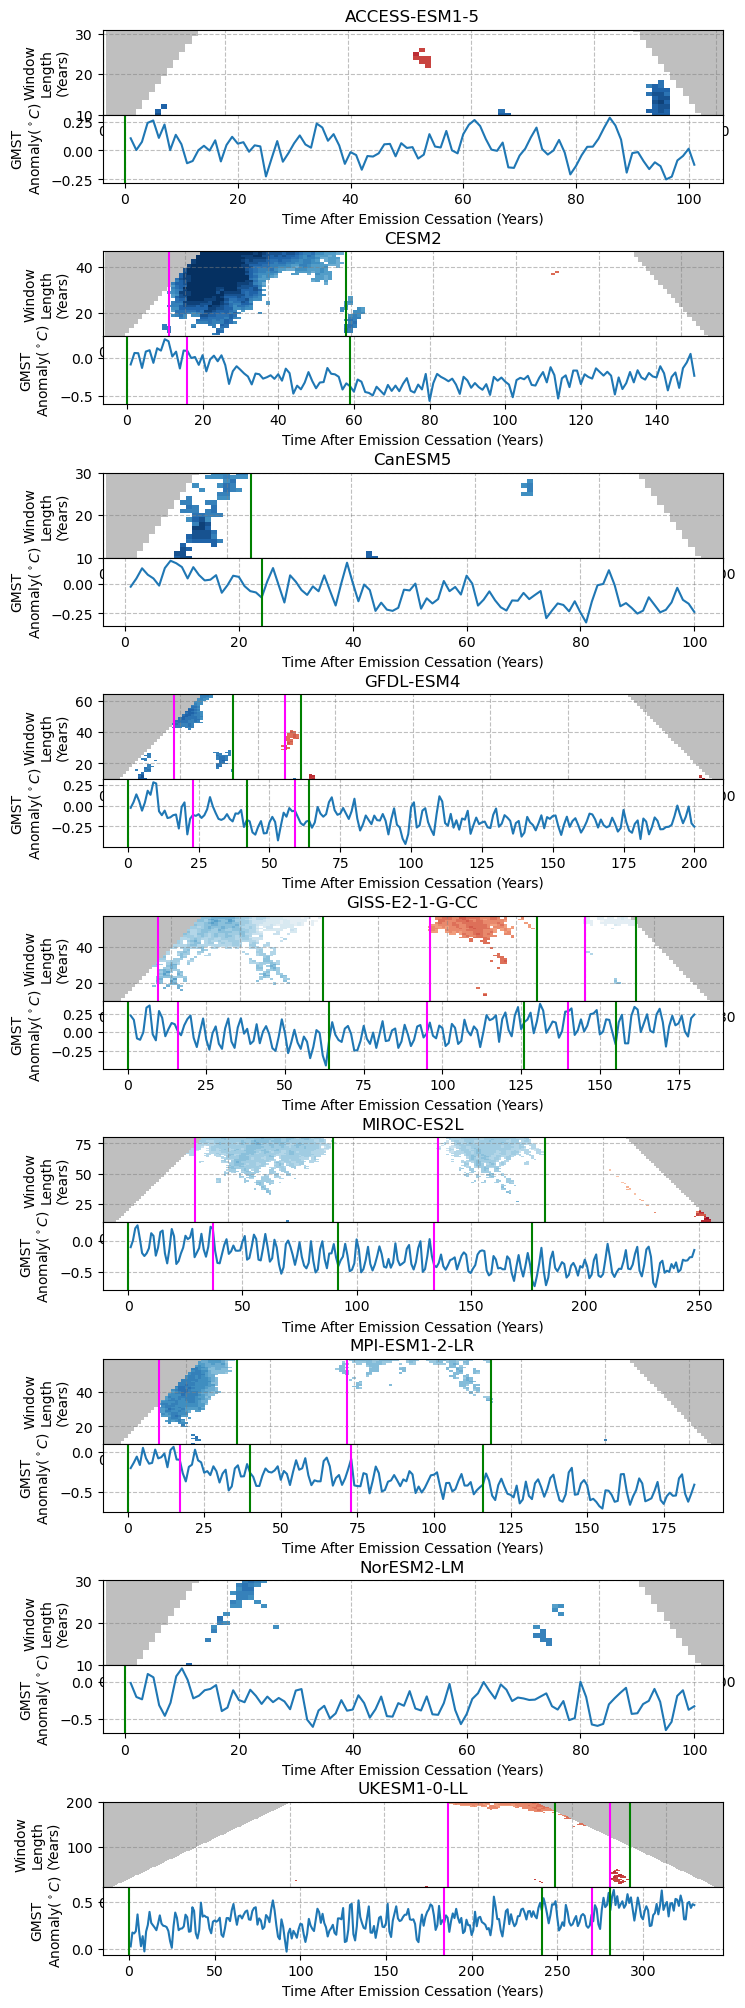

In [241]:
fig = plt.figure(figsize=(8, 25))
outer_gs = gridspec.GridSpec(9, 1, hspace=0.45)  # Single column with 10 rows

# Lists to store axes
upper_axes = []
lower_axes = []

# Loop through the grid positions
for i in range(9):  # 9 positions since we're skipping the 10th plot
    # Create a GridSpec for the inner plots (1 large and 1 small)
    inner_gs = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=outer_gs[i], hspace=0, height_ratios=[1, 0.8])
    
    # Large plot (upper plot)
    upper_ax = fig.add_subplot(inner_gs[0])
    upper_axes.append(upper_ax)
    
    # Small plot (lower plot)
    lower_ax = fig.add_subplot(inner_gs[1])
    lower_axes.append(lower_ax)


for num, model in enumerate(models):
    ax = upper_axes[num]
    ax_lower = lower_axes[num]

    unstable_rolling_ds.sel(model=model).sn.plot(
        y='window', ax=ax, cmap='RdBu_r', levels=np.arange(-4, 4.25, .25), add_colorbar=False)
    sn_plotting.grey_mask(ax,sn_rolling_nan_locs.sel(model=model))

    
    a1_model_ds = a1_smean_anom_ds.sel(model=model)
    ax_lower.plot(a1_model_ds.time.values, a1_model_ds.values)
    for num,year in enumerate(year_stable_and_unstable_rolling_ds.sel(model=model).values):
        ax.axvline(year, c=colors[num%2])
        ax_lower.axvline(year, c=colors[num%2])


    ax.set_xlim(0,model_window_information[model]['time_length'])
    ax2.set_xlim(0,model_window_information[model]['time_length'])
    ax.set_ylim(10, model_window_information[model]['max_window'])
    # ax.axvspan(74, 100, color='grey')
    # ax.axvspan(-half_window, 0, color='grey')
    # ax_lower.axvline(0, color='k', linewidth=3)
    # ax.set_xlim(-half_window,100)
    # ax_lower.set_xlim(-half_window,100)
    ax.set_title(model)

    ax.grid(True, linestyle='--', alpha=0.5, color='grey')
    ax_lower.grid(True, linestyle='--', alpha=0.5, color='grey')

    # ax.xaxis.set_label_position('top')
    # ax.xaxis.tick_top()
    ax.set_xlabel('')
    ax_lower.set_xlabel('Time After Emission Cessation (Years)')
    ax.set_ylabel('Window\nLength\n(Years)')
    ax_lower.set_ylabel('GMST\nAnomaly'+r'($^\circ C$)')
    # if num%2:
    #     ax.tick_params(axis='y', labelleft=False, labelright=True, which='both', direction='inout', length=6)    
    #     ax.yaxis.set_ticks_position('right')
    #     ax.spines['right'].set_position(('outward', 0))
    #     ax.yaxis.set_label_position('right')

    #     ax_lower.tick_params(axis='y', labelleft=False, labelright=True, which='both', direction='inout', length=6)
    #     ax_lower.yaxis.set_ticks_position('right')
    #     ax_lower.spines['right'].set_position(('outward', 0))
    #     ax_lower.yaxis.set_label_position('right')

In [242]:
# Set the ticks to be on the RHS
# if num%2:
#     ax.tick_params(axis='y', labelleft=False, labelright=True, 
#                    which='both', direction='inout', length=6)    
#     ax.yaxis.set_ticks_position('right')
#     ax.spines['right'].set_position(('outward', 0))
#     ax.yaxis.set_label_position('right')

#     ax_lower.tick_params(axis='y', labelleft=False, labelright=True,
#                          which='both', direction='inout', length=6)
#     ax_lower.yaxis.set_ticks_position('right')
#     ax_lower.spines['right'].set_position(('outward', 0))
    # ax_lower.yaxis.set_label_position('right')

In [243]:
sn_multi_rolling_control_ds
esmpi_smean_ds

<xarray.DataArray 'tas' (model: 9, time: 1880)> Size: 135kB
13.5 13.55 13.52 13.57 13.63 13.77 13.8 ... 13.16 13.31 13.44 13.31 13.31 13.15
Coordinates:
  * time     (time) object 15kB 0001-12-31 00:00:00 ... 1880-12-31 00:00:00
  * model    (model) <U14 504B 'MPI-ESM1-2-LR' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'

In [244]:
a1_smean_anom_ds.isel(model=0)

<xarray.DataArray 'tas' (time: 330)> Size: 3kB
-0.2001 -0.1323 -0.05384 -0.1603 0.05755 -0.07514 ... nan nan nan nan nan nan
Coordinates:
    model    <U14 56B 'MPI-ESM1-2-LR'
  * time     (time) int64 3kB 1 2 3 4 5 6 7 8 ... 324 325 326 327 328 329 330

In [245]:
time_leght = len(esmpi_smean_ds.sel(model=model).dropna(dim='time').time.values)
time_leght

1880

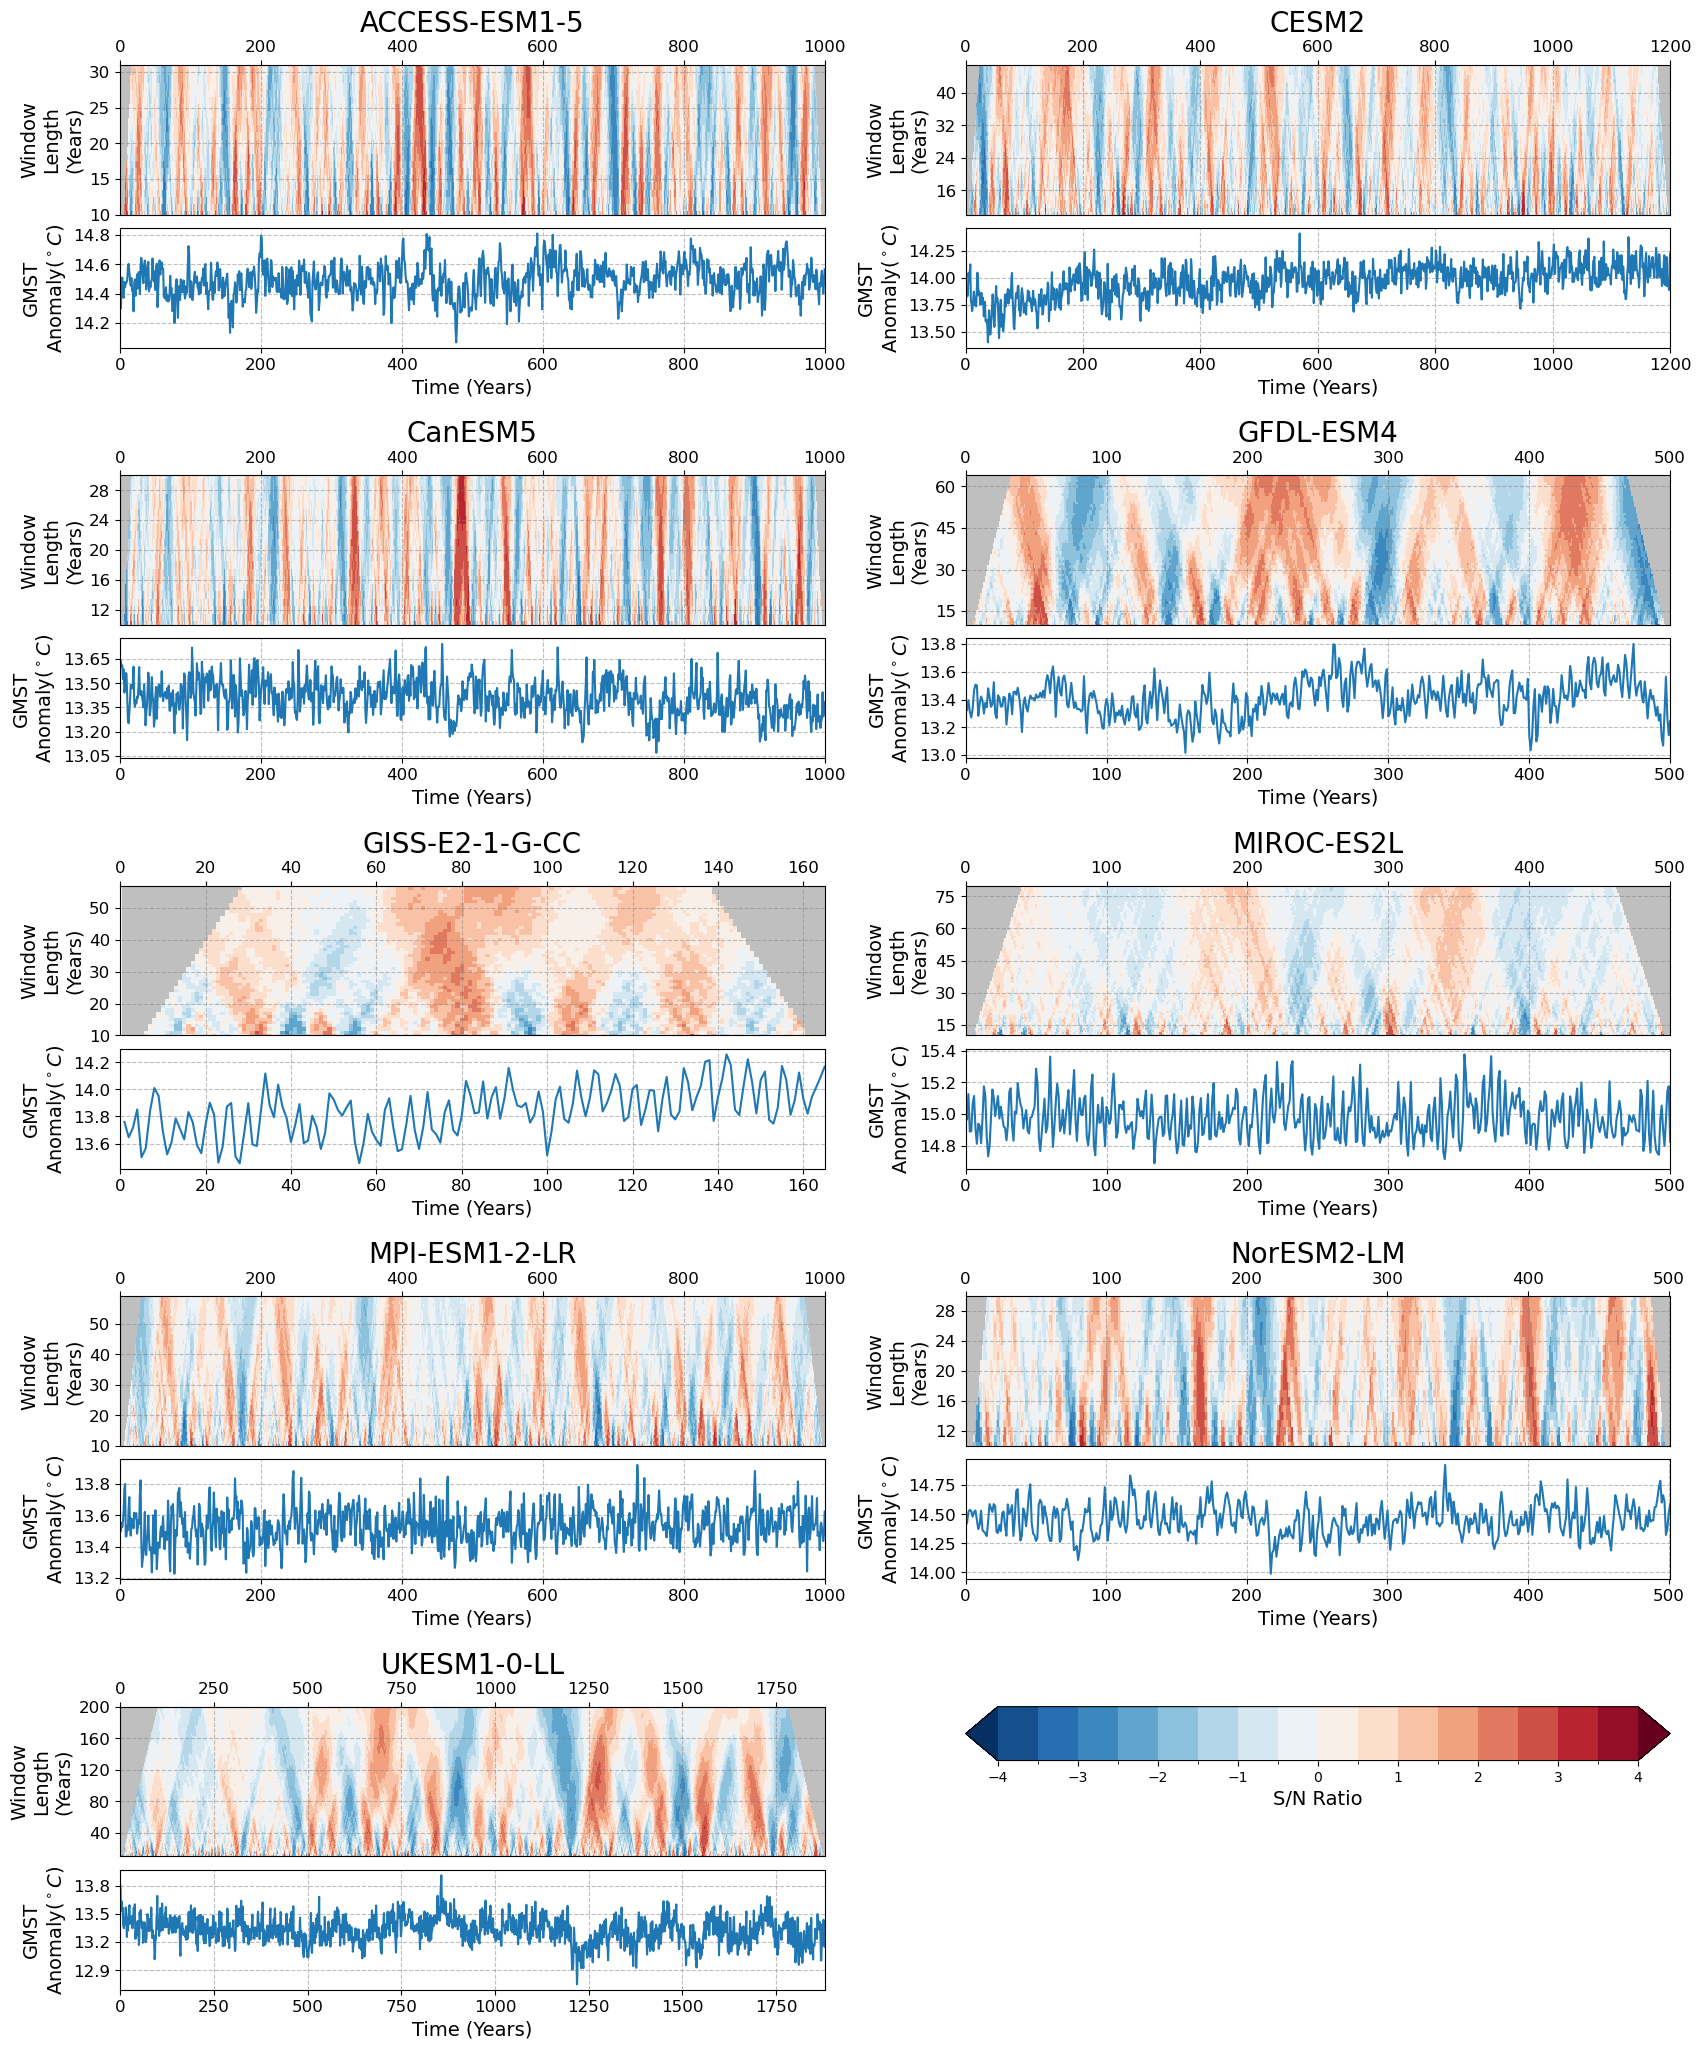

In [246]:

sn_ratio_levels = np.arange(-4, 4.5, .5)
fig = plt.figure(figsize=(20, 25))
outer_gs = gridspec.GridSpec(5, 2, hspace=0.45, wspace=0.2)

# Lists to store axes
upper_axes = []
lower_axes = []

# Loop through the grid positions
for i in range(5):
    for j in range(2):  # Loop over the two columns
        # Create a GridSpec for the inner plots (1 large and 1 small)

        if (i+1)*(j+1) <9: # Don't want the tench plot
            inner_gs = gridspec.GridSpecFromSubplotSpec(
                2, 1, subplot_spec=outer_gs[i, j], hspace=0.1,
                height_ratios=[1, 0.8])
            
            # Large plot (upper plot)
            upper_ax = fig.add_subplot(inner_gs[0])
            upper_axes.append(upper_ax)
            
            # Small plot (lower plot)
            lower_ax = fig.add_subplot(inner_gs[1])
            lower_axes.append(lower_ax)

for num, model in enumerate(models):
    ax = upper_axes[num]
    ax_lower = lower_axes[num]

    sn_multi_rolling_control_model_da = sn_multi_rolling_control_ds.sel(model=model)
    sn_multi_rolling_control_model_da['time'] = sn_multi_rolling_control_model_da.time.dt.year.values

    model_max_window = model_window_information[model]['max_window'] if 'UKESM' not in model else 200
    cplot = sn_multi_rolling_control_model_da.sel(
        window=slice(10, model_max_window)).plot(
        y='window', ax=ax, cmap='RdBu_r', levels=sn_ratio_levels, 
        add_colorbar=False, extend='both')
    sn_plotting.grey_mask(ax,np.isnan(sn_multi_rolling_control_model_da))

    
    esmpi_smean_model_ds = esmpi_smean_ds.sel(model=model)
    esmpi_smean_model_ds['time'] = esmpi_smean_model_ds.time.dt.year.values
    time_legth = len(esmpi_smean_model_ds.dropna(dim='time').time.values)
    ax_lower.plot(esmpi_smean_model_ds.time.values, esmpi_smean_model_ds.values)
    # ax_lower.plot(esmpi_smean_model_ds.time.values, esmpi_smean_model_ds.rolling(time=20).mean().values,
    #          color='green')
        
    # for num,year in enumerate(year_stable_and_unstable_rolling_ds.sel(model=model).values):
    #     ax.axvline(year, c=colors[num%2], linewidth=2)
    #     ax_lower.axvline(year, c=colors[num%2], linewidth=2)


    # ax.set_xlim(0,model_window_information[model]['time_length'])
    # ax_lower.set_xlim(0,model_window_information[model]['time_length'])
    ax.set_ylim(10, model_max_window)
    ax.set_title(model, fontsize=20)
    ax.set_xlim(0, time_legth)
    ax_lower.set_xlim(0, time_legth)


    ax.grid(True, linestyle='--', alpha=0.5, color='grey')
    ax_lower.grid(True, linestyle='--', alpha=0.5, color='grey')

    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xlabel('')
    ax_lower.set_xlabel('Time (Years)', fontsize=14)
    ax.set_ylabel('Window\nLength\n(Years)', fontsize=14)
    ax_lower.set_ylabel('GMST\nAnomaly'+r'($^\circ C$)', fontsize=14)
    ax_lower.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12) 
    ax_lower.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))


# Add colorbar to the lower right-hand side

inner_gs_cax = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=outer_gs[-1, -1], hspace=0.1,
    height_ratios=[0.2, 0.8])
cax = fig.add_subplot(inner_gs_cax[0])   
cbar = plt.colorbar(cplot, cax=cax, orientation='horizontal', extend='both')
cbar.set_label('S/N Ratio', fontsize=14)


In [409]:
# year_of_stabilisation_df.loc[model, f'stable_{stable_num}_avtemp']

In [407]:
year_of_stabilisation_df

zec50 final_temp zec50-final final_year_stable stable_0  \
model                                                                        
MPI-ESM1-2-LR  -0.270157      -0.49        0.22             116.0        0   
ACCESS-ESM1-5   0.011302       0.02       -0.01               0.0        0   
CESM2          -0.309638      -0.31         0.0              59.0        0   
CanESM5         -0.10173      -0.11        0.01              24.0       24   
GFDL-ESM4       -0.20539      -0.19       -0.02              64.0        0   
GISS-E2-1-G-CC -0.090083       0.12       -0.21             155.0        0   
MIROC-ES2L     -0.108559       -0.4        0.29             177.0        0   
NorESM2-LM      -0.33444      -0.27       -0.06               0.0        0   
UKESM1-0-LL     0.289383       0.45       -0.16             281.0        0   

               stable_period_temp_av_0 unstable_1  \
model                                               
MPI-ESM1-2-LR                    -0.07         17   
ACCESS-ESM1-5                     0.02        NaN   
CESM2                             0.05         16   
CanESM5                          -0.11        NaN   
GFDL-ESM4                        -0.03         23   
GISS-E2-1-G-CC                    0.09         16   
MIROC-ES2L                       -0.04         37   
NorESM2-LM                       -0.27        NaN   
UKESM1-0-LL                       0.27        184   

               unstable_period_temp_change_1 stable_2 stable_period_temp_av_2  \
model                                                                           
MPI-ESM1-2-LR                            0.0       40                   -0.27   
ACCESS-ESM1-5                            NaN      NaN                     NaN   
CESM2                                    0.0       59                   -0.31   
CanESM5                                  NaN      NaN                     NaN   
GFDL-ESM4                                0.0       42                   -0.21   
GISS-E2-1-G-CC                           0.0       64                   -0.05   
MIROC-ES2L                               0.0       92                   -0.28   
NorESM2-LM                               NaN      NaN                     NaN   
UKESM1-0-LL                              0.0      241                    0.34   

               unstable_3 unstable_period_temp_change_3 stable_4  \
model                                                              
MPI-ESM1-2-LR          73                           0.0      116   
ACCESS-ESM1-5         NaN                           NaN      NaN   
CESM2                 NaN                           NaN      NaN   
CanESM5               NaN                           NaN      NaN   
GFDL-ESM4              59                           0.0       64   
GISS-E2-1-G-CC         95                           0.0      126   
MIROC-ES2L            134                           0.0      177   
NorESM2-LM            NaN                           NaN      NaN   
UKESM1-0-LL           270                           0.0      281   

               stable_period_temp_av_4 unstable_5  \
model                                               
MPI-ESM1-2-LR                    -0.49        NaN   
ACCESS-ESM1-5                      NaN        NaN   
CESM2                              NaN        NaN   
CanESM5                            NaN        NaN   
GFDL-ESM4                        -0.19        NaN   
GISS-E2-1-G-CC                    0.15        140   
MIROC-ES2L                        -0.4        NaN   
NorESM2-LM                         NaN        NaN   
UKESM1-0-LL                       0.45        NaN   

               unstable_period_temp_change_5 stable_6 stable_period_temp_av_6  
model                                                                          
MPI-ESM1-2-LR                            NaN      NaN                     NaN  
ACCESS-ESM1-5                            NaN      NaN                     NaN  
CESM2                          

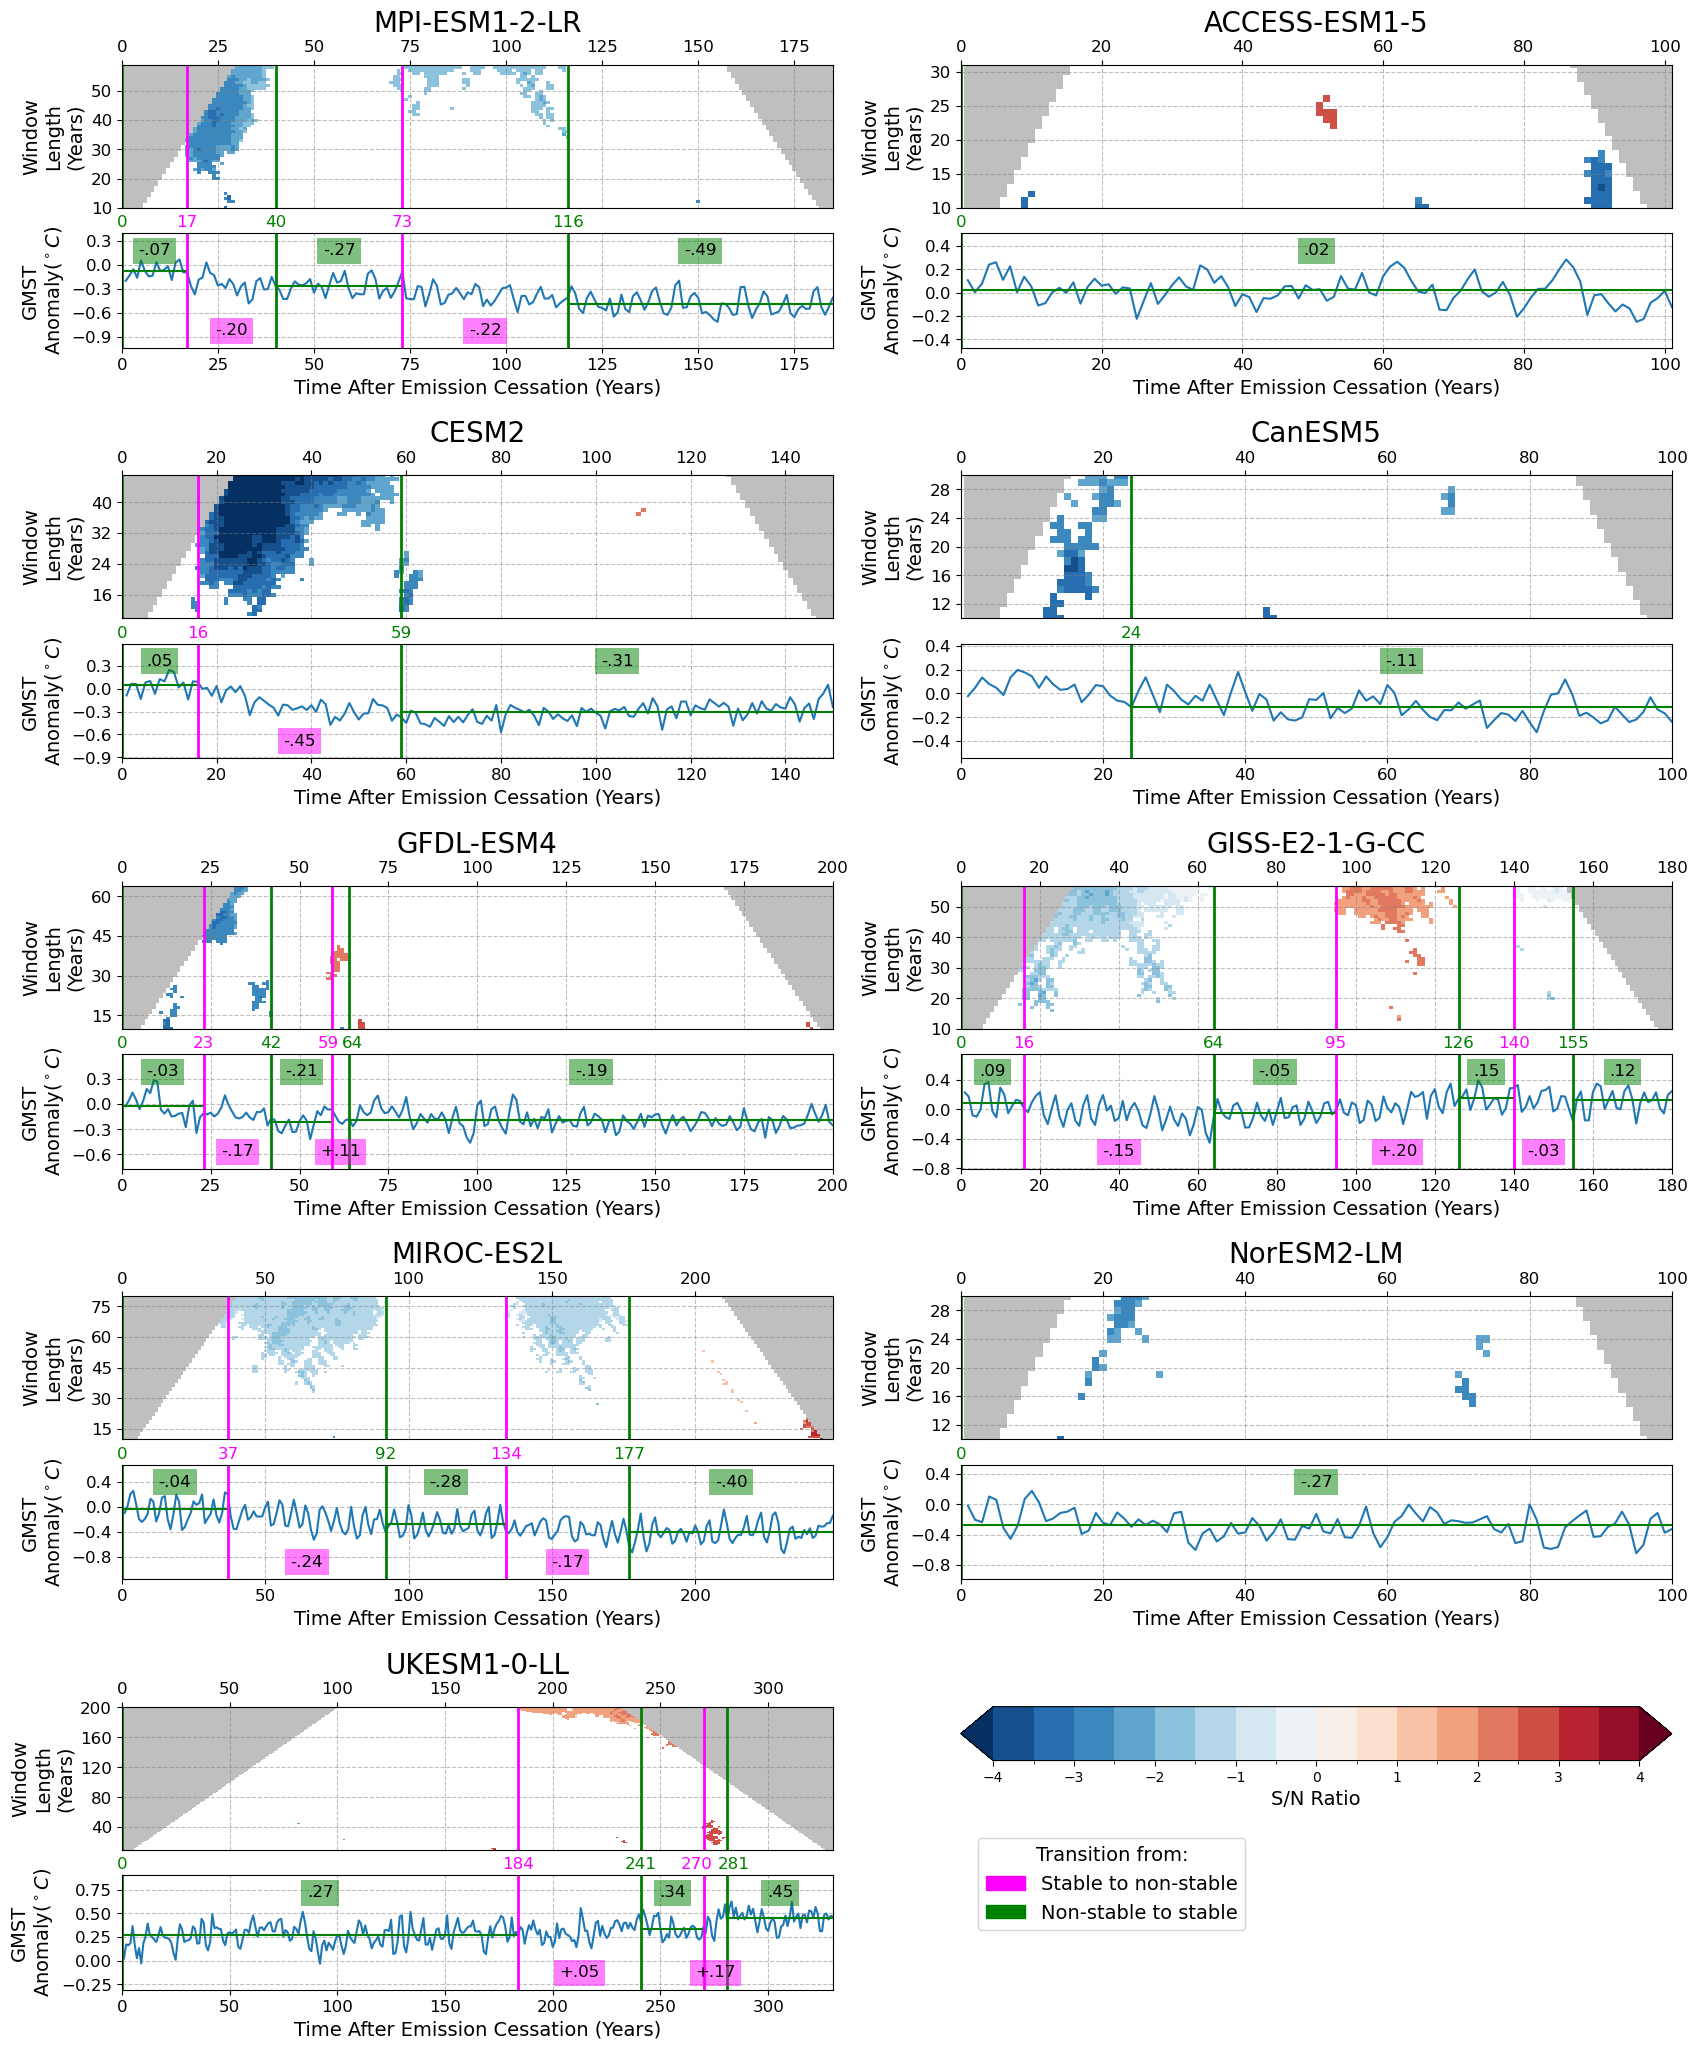

In [478]:

sn_ratio_levels = np.arange(-4, 4.5, .5)
fig = plt.figure(figsize=(20, 25))
outer_gs = gridspec.GridSpec(5, 2, hspace=0.45, wspace=0.18)

# Lists to store axes
upper_axes = []
lower_axes = []

# Loop through the grid positions
for i in range(5):
    for j in range(2):  # Loop over the two columns
        # Create a GridSpec for the inner plots (1 large and 1 small)

        if (i+1)*(j+1) <9: # Don't want the tench plot
            inner_gs = gridspec.GridSpecFromSubplotSpec(
                2, 1, subplot_spec=outer_gs[i, j], hspace=0.2,
                height_ratios=[1, 0.8])
            
            # Large plot (upper plot)
            upper_ax = fig.add_subplot(inner_gs[0])
            upper_axes.append(upper_ax)
            
            # Small plot (lower plot)
            lower_ax = fig.add_subplot(inner_gs[1])
            lower_axes.append(lower_ax)

for num, model in enumerate(models):
    ax = upper_axes[num]
    ax_lower = lower_axes[num]

    cplot = unstable_rolling_ds.sel(model=model).sn.plot(
        y='window', ax=ax, cmap='RdBu_r', levels=sn_ratio_levels, 
        add_colorbar=False, extend='both')
    sn_plotting.grey_mask(ax,sn_rolling_nan_locs.sel(model=model))

    
    a1_model_ds = a1_smean_anom_ds.sel(model=model)
    ax_lower.plot(a1_model_ds.time.values, a1_model_ds.values)
    # ax_lower.plot(a1_model_ds.time.values, a1_model_ds.rolling(time=20).mean().values,
    #          color='green')

    year_vals = year_stable_and_unstable_rolling_ds.sel(model=model).values
    year_vals = year_vals[np.isfinite(year_vals)].astype(int)
    # year_vals = year_vals[year_vals>0]

    for num in range(len(year_vals)):
        if num == len(year_vals)-1:
            # str_xloc = year_vals[num]+10
            str_xloc = (model_window_information[model]['time_length'] +year_vals[num])/2
            yloc = 0.85
        elif not num%2:
            str_xloc = (year_vals[num]+year_vals[num+1])/2
            yloc = 0.85
        else:
            # str_xloc = year_vals[num+1]
            str_xloc = (year_vals[num]+year_vals[num+1])/2
            yloc = 0.15

        if not num%2: # Stable period
            temp = year_of_stabilisation_df.loc[model, f'stable_period_temp_av_{num}']
            # temp_str = f'T_av=\n{temp:.2f}'
            color = 'green'
        else:
            temp = year_of_stabilisation_df.loc[model, f'unstable_period_temp_change_{num}']
            # temp_str = f'delta T=\n{temp:.2f}'
            color = 'magenta'
        # temp_str = f'{temp:.2f}'
        sign = '+' if temp >= 0 else '-'  # Determine the sign
        if not num%2 and sign == '+':
            sign = ''
        temp_str = f'{sign}.'+  f"{abs(temp):.2f}".split('.')[-1] 

        
        
        ax_lower.annotate(temp_str, xy=(str_xloc, yloc), xycoords=('data', 'axes fraction'),
                   fontsize=12, ha='center', va='center', 
                          bbox=dict(facecolor=color, edgecolor='none', alpha=0.5)
                          # color=color
                          )
            
    for num,year in enumerate(year_vals):
        ax.axvline(year, c=colors[num%2], linewidth=2)
        # year_str = str(year)
        if 'UKESM' in model:
            if year == 270:
                year_loc = year-3
            elif year == 281:
                year_loc = year+3 
            else:
                year_loc = year
        elif 'GFDL' in model:
            if year == 59:
                year_loc = year-1
            elif year == 64:
                year_loc = year+1 
            else:
                year_loc = year
        else:
            year_loc = year

        ax.annotate(year, xy=(year_loc, -0.05),
                    xycoords=('data', 'axes fraction'),
                    color=colors[num%2], fontsize=12, clip_on=False,
                    ha='center', va='top')
        ax_lower.axvline(year, c=colors[num%2], linewidth=2)

        if not num%2:
            temp = year_of_stabilisation_df.loc[model, f'stable_period_temp_av_{num}']
            if num == len(year_vals)-1 :
                end_line = model_window_information[model]['time_length']
            else:
                end_line = year_vals[num+1]
            start_line = year
            ax_lower.plot([start_line, end_line], [temp, temp], color='green')


    ax.set_xlim(0,model_window_information[model]['time_length'])
    ax_lower.set_xlim(0,model_window_information[model]['time_length'])
    ylim = model_window_information[model]['max_window']# if 'UKESM' not in model else 200
    ax.set_ylim(10, ylim)
    ax.set_title(model, fontsize=20)

    ax.grid(True, linestyle='--', alpha=0.5, color='grey')
    ax_lower.grid(True, linestyle='--', alpha=0.5, color='grey')

    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xlabel('')
    ax_lower.set_xlabel('Time After Emission Cessation (Years)', fontsize=14)
    ax.set_ylabel('Window\nLength\n(Years)', fontsize=14)
    ax_lower.set_ylabel('GMST\nAnomaly'+r'($^\circ C$)', fontsize=14)
    ax_lower.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12) 
    ylim_frac = np.diff(np.array(ax_lower.get_ylim()))[0]/3
    ax_lower.set_ylim(ax_lower.get_ylim()[0]-ylim_frac, ax_lower.get_ylim()[-1]+ylim_frac)
    ax_lower.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))


# Add colorbar to the lower right-hand side

inner_gs_cax = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=outer_gs[-1, -1], hspace=0.1,
    height_ratios=[0.2, 0.8])
cax = fig.add_subplot(inner_gs_cax[0])   
cbar = plt.colorbar(cplot, cax=cax, orientation='horizontal', extend='both')
cbar.set_label('S/N Ratio', fontsize=14)

magenta_patch = mpatches.Patch(color='magenta', label='Stable to non-stable')
green_patch = mpatches.Patch(color='green', label='Non-stable to stable' )
leg = fig.legend(handles=[magenta_patch, green_patch], loc='lower center',
                 ncol=1, fontsize=14, bbox_to_anchor=[0.62, 0.13])
leg.set_title('Transition from:', prop={'size': 14})

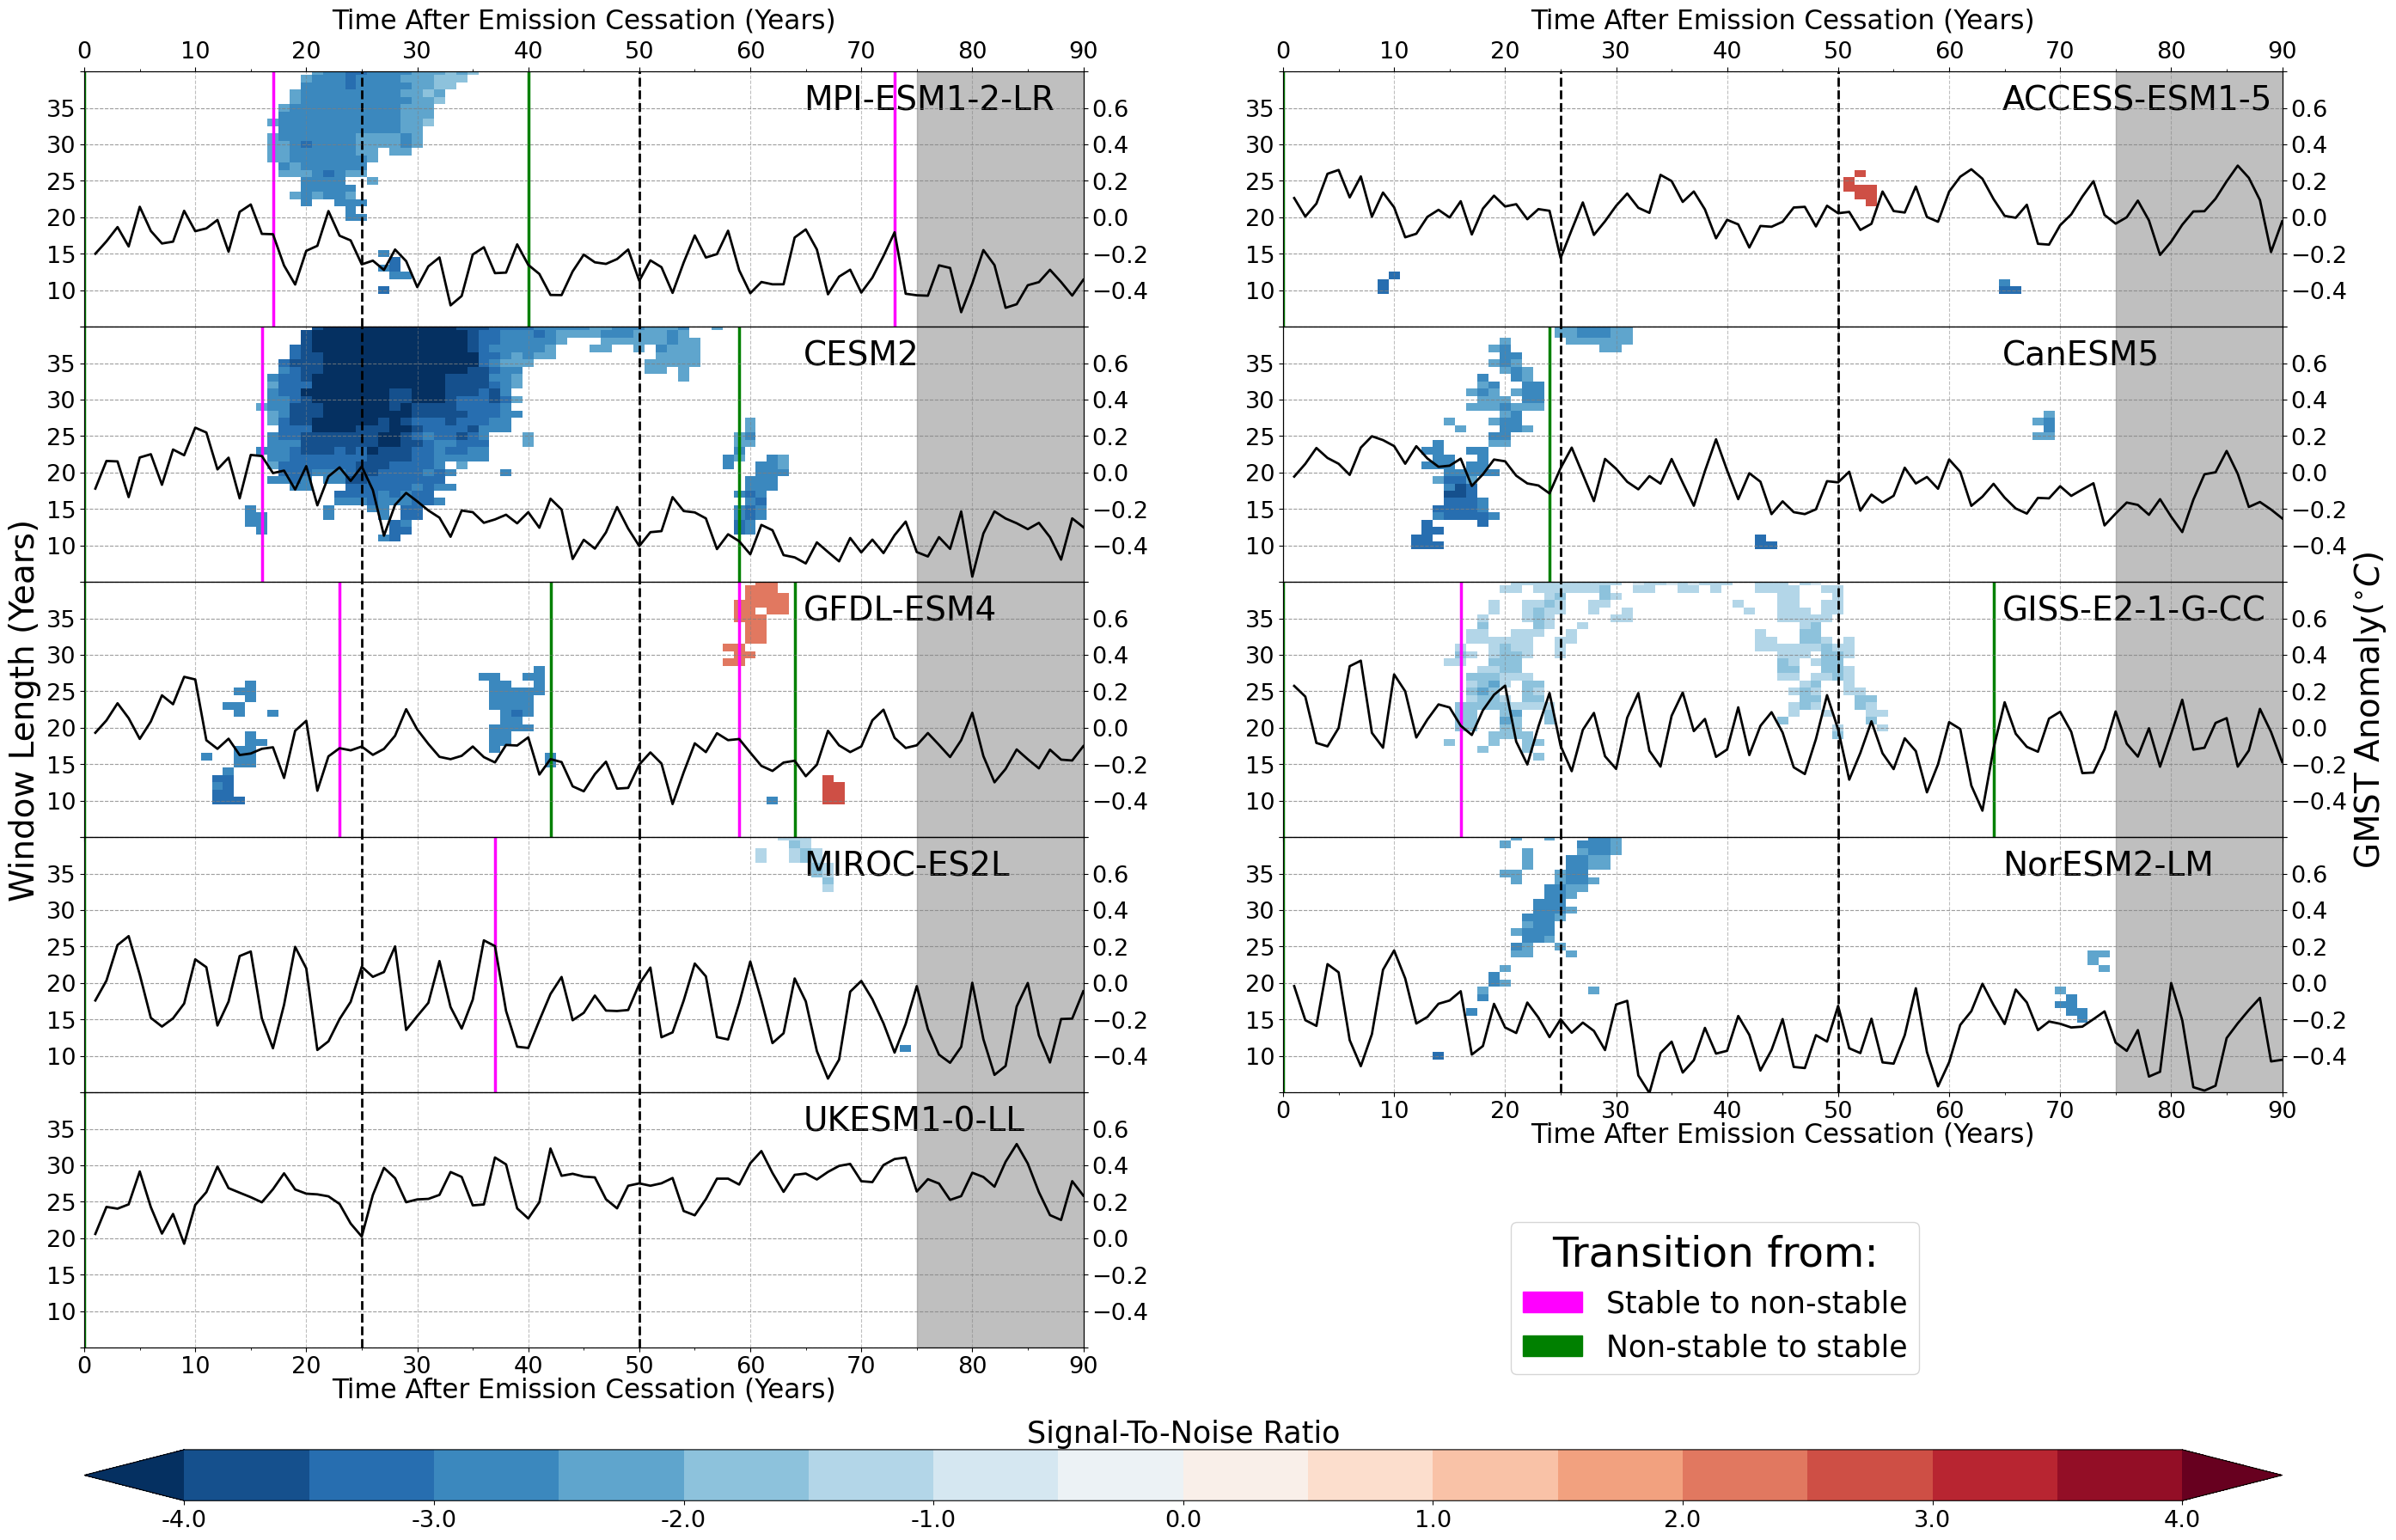

In [248]:
%matplotlib inline
models = unstable_rolling_ds.model.values
font_scale = 1.4

num_plots = len(models)
num_cols = 2
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*1.5,  sn_plotting.plot_kwargs['height']*num_plots/5))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.4]+[0.2],hspace=0, wspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]

for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if  num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num_rows+1, :])
    
    fig, returned_axes = sn_plotting.sn_multi_window_in_time(
        unstable_rolling_ds.sel(model=model).squeeze().sn.isel(time=slice(0, 75)),
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        fig=fig, gs=gs, ax=axes[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title='', yticks_right = np.arange(-0.6, 1, .2), **stability_colorplot_kwargs) 
    
    ax, ax2, cax = returned_axes

    # Lines at zec25 and zec50
    ax.axvline(25, 0, 1000, color='k', linewidth=2, linestyle='--')
    ax.axvline(50, 0, 1000, color='k', linewidth=2, linestyle='--')

    for snum,year in enumerate(year_stable_and_unstable_rolling_ds.sel(model=model).values):
        ax.axvline(year, c=line_colors[snum%2], linewidth=2.5)

    ax.axvspan(75, 100, color='grey', alpha=0.5)

    
    plotting_functions.clip_axis_ends(ax)
    plotting_functions.clip_axis_ends(ax2)

    ax.set_ylabel('')
    ax2.set_ylabel('')
    if num  == 4: ax.set_ylabel('Window Length (Years)', size=plotting_functions.PlotConfig.title_size*font_scale)
    if num  == 5: ax2.set_ylabel(f'GMST Anomaly({units})', size=plotting_functions.PlotConfig.title_size*font_scale)
    ax.annotate(model, xy=(0.72, 0.85), xycoords='axes fraction', ha='left', size=plotting_functions.PlotConfig.title_size*font_scale)
    if num <= 1:
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
    
    if 1 < num < 7:
        ax.set_xticklabels([])
        ax.set_xlabel('')

magenta_patch = mpatches.Patch(color='magenta', label='Stable to non-stable')
green_patch = mpatches.Patch(color='green', label='Non-stable to stable' )
leg = fig.legend(handles=[magenta_patch, green_patch], loc='lower center', ncol=1, fontsize=25, bbox_to_anchor=[0.7, 0.17])
leg.set_title('Transition from:', prop={'size': 35})

## Supplementary Figures

### Figure S1 (ZEC Time Series)

In [263]:
models = a1_smean_anom_ds.model.values

In [264]:

def plot_zecmip_data(ax, a1_model_subset, pct_model_subset, zec50_anom, zec25_anom):
    branch_year = a1_model_subset.time.values[0].year
    base_period_years =  np.arange(branch_year-10, branch_year+10)
    
    pct_brach_subset = pct_model_subset.sel(
        time=pct_model_subset.time.dt.year.isin(base_period_years))

    a1_time = np.arange(0, len(a1_model_subset.time.values))
    pct_time = np.arange(-10, 10)
    
    base_period_mean = pct_brach_subset.mean(dim='time').values
    
    
    ax.plot(
        a1_time,
        # a1_model_subset.time.values,
        np.tile(base_period_mean, len(a1_model_subset.time.values)),
        linestyle='--', color='k', label='Base Period Average')
    
    ax.plot(pct_time, pct_brach_subset.values, color='magenta', label='Base Period',
           # linestyle='--', marker='o'
           )
    
    ax.plot(a1_time, a1_model_subset.values, color='green', linewidth=2, label='A1')

    #### ZEC50
    zec50_loc = a1_model_subset.isel(time=slice(40, 60)).mean().values
    # zec50_val= zec50_loc
    ax.plot(np.arange(40, 60),
            np.tile(zec50_loc, 20),
            color='blue', linewidth=2)
    if zec50_loc < base_period_mean: ytrans = -0.2
    else: ytrans = 0.2
    ax.annotate(f'{zec50_anom:.2f}', xy=(50,zec50_loc+ytrans), ha='center', color='blue')

    ### ZEC25
    zec25_loc = a1_model_subset.isel(time=slice(15, 35)).mean().values
    # zec50_val= zec50_loc
    ax.plot(np.arange(15, 35),
            np.tile(zec25_loc, 20),
            color='brown', linewidth=2)
    if zec25_loc < base_period_mean: ytrans = -0.2
    else: ytrans = 0.2
    ax.annotate(f'{zec25_anom:.2f}', xy=(25,zec25_loc+ytrans), ha='center', color='brown')
    
    
    ax.axvline(0, label='Branch Point')
    
    ### Styling
    ax.grid(True, linestyle='--', color='grey', alpha=0.5)

Text(0.5, 0, 'Time After Emission Cessation (Years)')

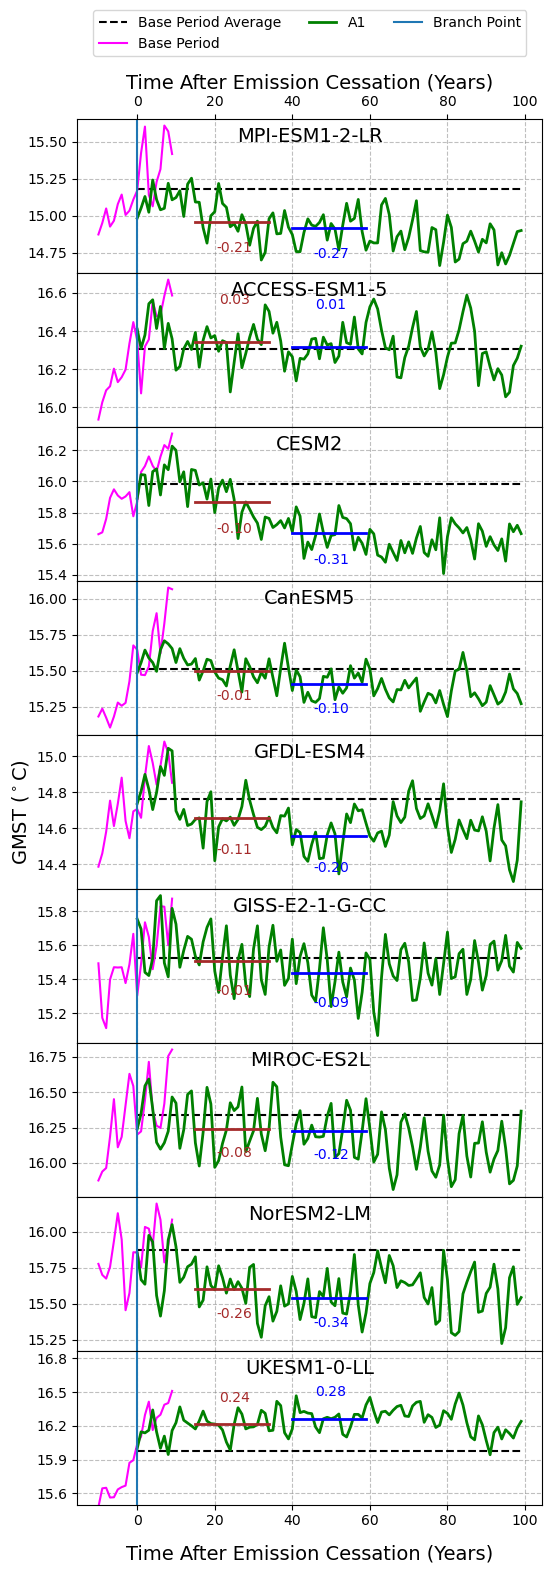

In [265]:
# ncols = 2
# nrows = int(np.ceil(len(models)/ncols))

# fig = plt.figure(figsize=(6*ncols, 2*nrows))
# gs = gridspec.GridSpec(nrows, ncols, hspace=0.2, wspace=0.1)
# axes = [fig.add_subplot(gs[i]) for i in range(9)]

ncols = 1
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

# Iterate over the models and plot each one using plot_model_data
for num, model in enumerate(pct_smean_xrlist.refkeys):
    plot_zecmip_data(axes[num], a1_smean_xrlist[model].squeeze(), pct_smean_xrlist[model].squeeze(),
                    zec50_ds.sel(model=model).values.item(), zec25_ds.sel(model=model).values.item())
    # plot_model_data(axes[num], model, ds_pct, a1_smean_xrlist[model])
    axes[num].annotate(model, xy=(0.5, 0.85), ha='center', fontsize=14, xycoords='axes fraction')

    if model == 'UKESM1-0-LL': axes[num].set_ylim(15.5, 16.87)
    axes[num].yaxis.set_major_locator(MaxNLocator(nbins=5))
    # Add y-axis label to the middle left subplot
    if num == int(len(models)/2):
        axes[num].set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)

    if num == 0:
        axes[num].xaxis.set_label_position('top')
        axes[num].xaxis.tick_top()
    


# Place the legend above the first row of plots
# leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)
leg = axes[0].legend(ncol=3, bbox_to_anchor=[0.5, 1.75], loc='upper center', fontsize=10)

# Add x-axis label to the last subplot
axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)
axes[0].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=2)

### Figure S2 (Global Drift)

In [266]:
import pymannkendall

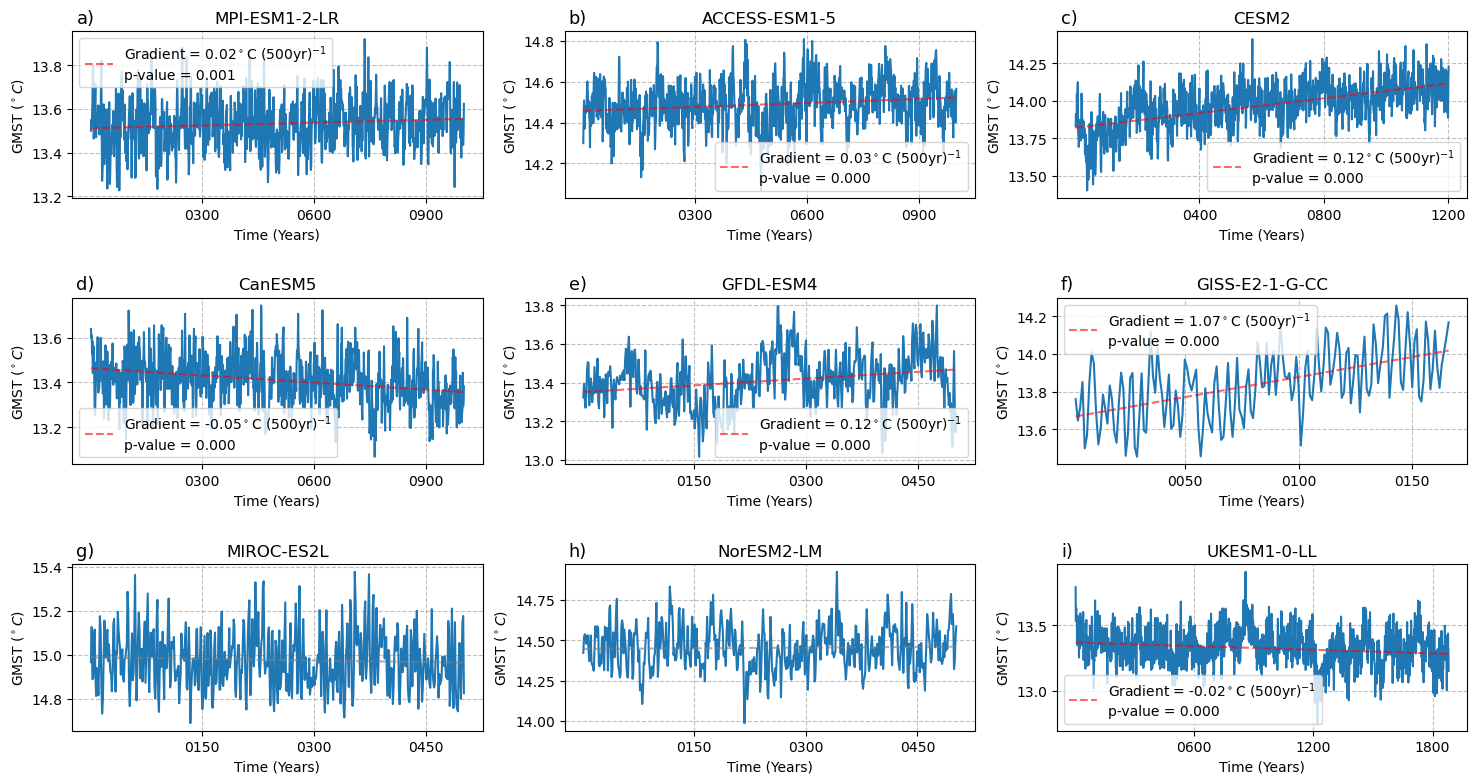

In [267]:
models = esmpi_smean_xrlist.refkeys
ncols = 3; nrows = int(np.ceil(len(models)/2))

fig = plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, hspace=0.6)

for num, (model, ds) in enumerate(esmpi_smean_xrlist):
    ax = fig.add_subplot(gs[num])
    time = utils.convert_to_0_start_cftime(ds.time.values)
    ax.plot(time,ds.squeeze())
    
    plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=0.8)
    ax.set_title(model); ax.set_ylabel(r'GMST $(^\circ C)$'); ax.set_xlabel('Time (Years)')
    # ax.set_xlim([time[0], time[-1]])
    
    init_y = ds.squeeze().values
    x = np.arange(len(init_y))
    grad_yint = np.polyfit(x, init_y, deg=1)

    fitted_line = np.polyval(grad_yint, x)
    mk_val = pymannkendall.original_test(init_y)
    mk_pval = mk_val.p
    if mk_pval < 0.05:
        color = 'red'
        label = f'Gradient = {grad_yint[0]*500:.2f}' + r'$^\circ$C (500yr)$^{-1}$' + f'\np-value = {mk_pval:.3f}'
    else:
        color='grey'
        label=None
    
    ax.plot(time, fitted_line, linestyle='--', alpha=0.6, color=color, label=label)
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    if mk_pval < 0.05: ax.legend(ncol=1, loc='best')#bbox_to_anchor=(0.6, 1.06))

### Fig S3 ( Method Demonstration)

In [268]:
# Manual Calculation for Demonstations
WINDOW=25
# Sample period is the years that we want to look at
sample_period = (half_window,70+half_window) #(1200,1261), 61

# The length of the sample_period varible
window_length = WINDOW
imodel = 2

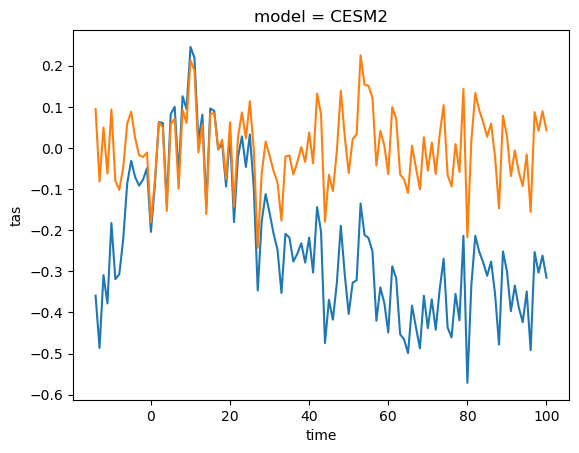

In [269]:
a1_smean_anom_ds.isel(model=imodel).plot()
a1_smean_anom_detrend_ds.isel(model=imodel).plot()

In [270]:
half_window

15

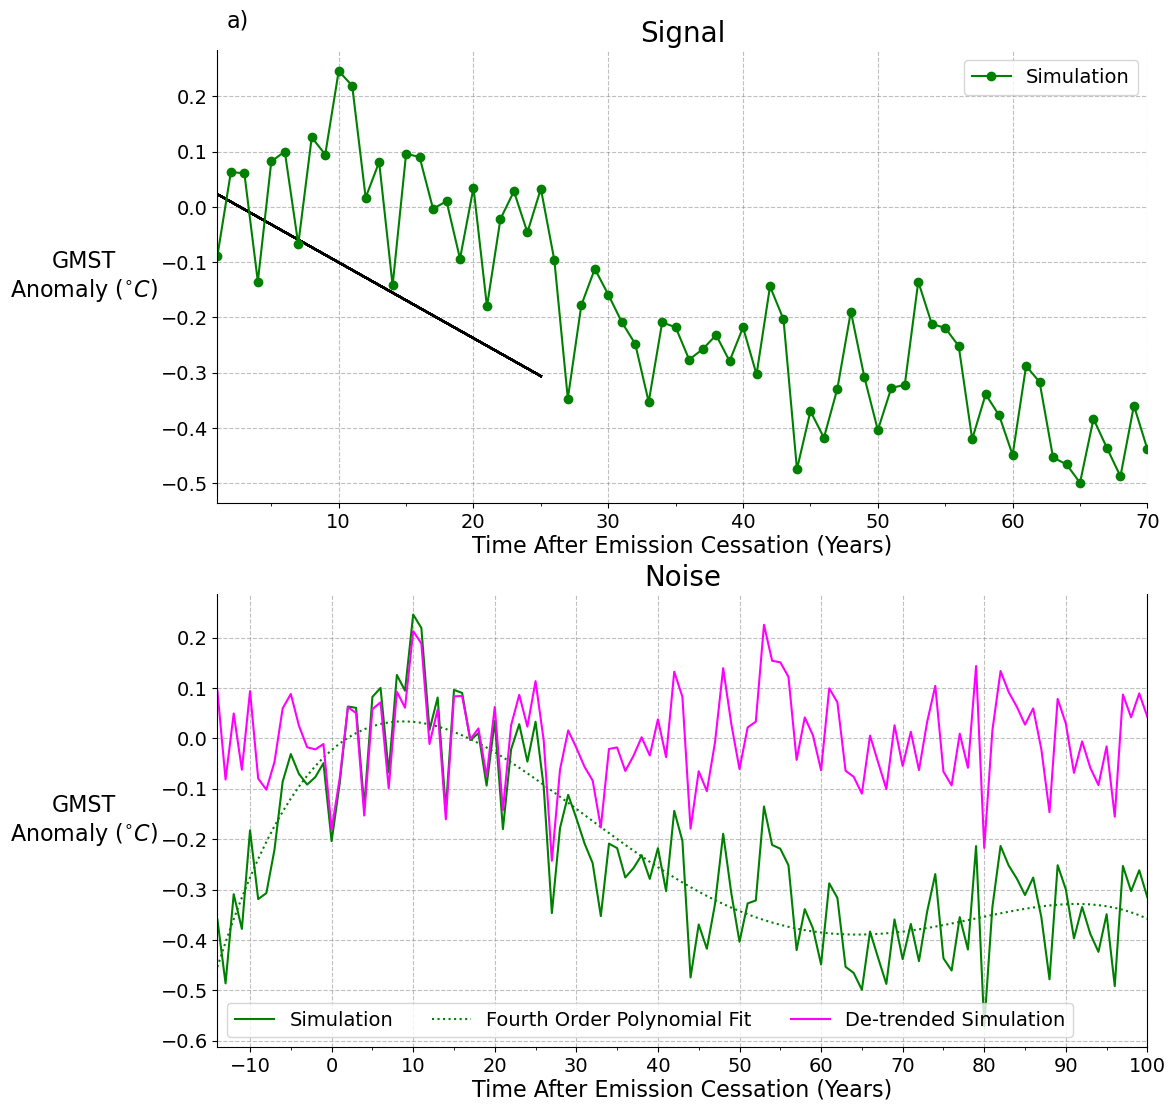

In [271]:
plt.style.use('default')
fig = plt.figure(figsize=(12,20))
axes = [fig.add_subplot(3,1,i) for i in range(1,3)]


# ---> axes[0]
# axes[0].plot(sample_data.time.dt.year.values, a1_smean_anom_trendfit_ds.isel(time=slice(*sample_period), model=imodel),
#              label='Linear Trend Fit', color='blue')
time_slice = slice(half_window, window_length+half_window)
sample_data = a1_smean_anom_ds.isel(time=slice(*sample_period), model=imodel)



for window_length in range(10, 30):
    arr = sample_data.isel(time=time_slice)
    x = np.arange(len(arr))
    coeffs= np.polyfit(x, arr, deg=1)
    yhat = np.polyval(coeffs, x)
    axes[0].plot(sample_data.time.values[:len(yhat)], yhat, color='black')

axes[0].plot(sample_data.time.values, sample_data.values, marker='o', label='Simulation',
             color='green')


axes[0].set_xlim(sample_data.time.values[0], sample_data.time.values[-1])
axes[0].legend(ncol=2, fontsize=plotting_functions.PlotConfig.legend_text_size)

plotting_functions.format_axis(axes[0], title='Signal', xlabel='Time After Emission Cessation (Years)', ylabel='GMST\n'+r'Anomaly ($^{\circ}C$)',
                               labelpad=55, invisible_spines=['top', 'right'])
plotting_functions.add_figure_label(axes[0], 'a)')
sn_plotting.format_ticks_as_years(axes[0], sample_data.time.values, logginglevel='ERROR')

# ---> axes[1]
# ax1 = axes[1]; ax2 = ax1#axes[1].twinx()
ax1 = axes[1]
time = a1_smean_anom_ds.time.values
lns1 = ax1.plot(time, a1_smean_anom_ds.isel(model=imodel).values, color='green', label='Simulation')
lns2 = ax1.plot(time, a1_smean_anom_trendfit_ds.isel(model=imodel).values, label='Fourth Order Polynomial Fit',
                color='green', linestyle=':')
lns3 = ax1.plot(time, a1_smean_anom_detrend_ds.isel(model=imodel).values, label='De-trended Simulation',
                color='magenta')
sn_plotting.format_ticks_as_years(axes[1], time, logginglevel='ERROR')
ax1.set_xlim(np.take(time, [0, -1]))

plotting_functions.format_axis(ax1, title='Noise', xlabel='Time After Emission Cessation (Years)', ylabel='GMST\n'+r'Anomaly ($^{\circ}C$)',
                               labelpad=55, invisible_spines=['top'])

ax1.legend(ncol=3, loc='best', fontsize=plotting_functions.PlotConfig.legend_text_size)# let
# plotting_functions.match_ticks(ax1, ax2, 'left')

# lns = lns1+lns2+lns3
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, ncol=3, loc='best', fontsize=plotting_functions.PlotConfig.legend_text_size)
# plotting_functions.format_axis(ax2, title='Noise', ylabel='GMST\nAnomaly\nDetrended' + r'($^{\circ}C$)',
#                                labelpad=55, invisible_spines=['top'])
# plotting_functions.add_figure_label(ax1, 'b)')

# Figure S4 (Stable and unstable demonstration)

AttributeError: 'DataArray' object has no attribute 'dt'

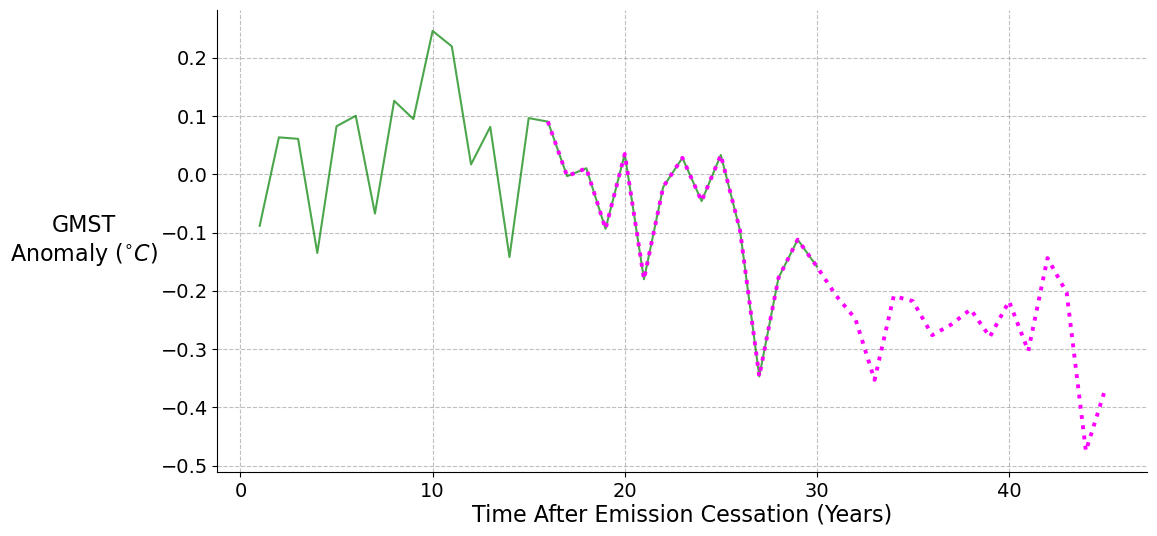

In [272]:
plt.style.use('default')
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

a1_smean_anom_ds.sel(model='CESM2').isel(time=slice(15, 45)).plot(color='green', alpha=0.7)
a1_smean_anom_ds.sel(model='CESM2').isel(time=slice(30, 60)).plot(
    color='magenta',linestyle=':', linewidth=2.8)

plotting_functions.format_axis(
    ax1, xlabel='Time After Emission Cessation (Years)', title='',
    ylabel='GMST\n'+r'Anomaly ($^{\circ}C$)',
    labelpad=55, invisible_spines=['top', 'right'])
ax1.set_title('')

# sn_plotting.format_ticks_as_years(ax1, a1_smean_anom_ds.isel(time=slice(15, 60)).time.dt.year.values,
#                                   logginglevel='ERROR')

ax1.set_xticklabels(a1_smean_anom_ds.isel(time=slice(14, 60)).time.dt.year.values[::15])

In [ ]:
a1_smean_anom_ds.sel(model='CESM2').isel(time=slice(15, 45)).plot(color='green', alpha=0.7)
a1_smean_anom_ds.sel(model='CESM2').isel(time=slice(30, 60)).plot(color='magenta',linestyle=':',
                                                                 linewidth=2.8)

### Figure S4-S6 (S, S/N, N at each window)

In [ ]:
sn_multi_static_da

In [ ]:
stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=False, ax2_ylabel='', ylabel='',
                                  cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
                                  cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio', hspace=0.2,
                                  return_all=True, rotation=90)

In [ ]:
%matplotlib inline
models = unstable_rolling_ds.model.values
font_scale = 1.4


num_plots = len(models)
num_cols = 2
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*1.5,  sn_plotting.plot_kwargs['height']*num_plots/5))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.4]+[0.2],hspace=0, wspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]

for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if  num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num_rows+1, :])
    
    fig, returned_axes = sn_plotting.sn_multi_window_in_time(
        sn_multi_rolling_ds.sel(model=model).isel(time=slice(None, 50)).squeeze().signal_to_noise,
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        # stable_point_ds = rolling_year_stable_ds.sel(model=model),#rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title='', yticks_right = np.arange(-0.6, 1, .2), **stability_colorplot_kwargs) 
    
    ax, ax2, cax = returned_axes
    
    # Lines at zec25 and zec50
    ax.axvline(25, 0, 1000, color='k', linewidth=2, linestyle='--')
    ax.axvline(50, 0, 1000, color='k', linewidth=2, linestyle='--')

    for snum,year in enumerate(year_stable_and_unstable_static_ds.sel(model=model).values):
        ax.axvline(year, c=line_colors[snum%2], linewidth=2.5)

    ax.axvspan(50, 90, color='grey', alpha=0.5)

    
    plotting_functions.clip_axis_ends(ax)
    plotting_functions.clip_axis_ends(ax2)

    ax.set_ylabel('')
    ax2.set_ylabel('')
    if num  == 4: ax.set_ylabel('Window Length (Years)', size=plotting_functions.PlotConfig.title_size*font_scale)
    if num  == 5: ax2.set_ylabel(f'GMST Anomaly({units})', size=plotting_functions.PlotConfig.title_size*font_scale)
    ax.annotate(model, xy=(0.72, 0.85), xycoords='axes fraction', ha='left', size=plotting_functions.PlotConfig.title_size*font_scale)
    if num <= 1:
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
    
    if 1 < num < 7:
        ax.set_xticklabels([])
        ax.set_xlabel('')

magenta_patch = mpatches.Patch(color='magenta', label='Non-stable to stable')
green_patch = mpatches.Patch(color='green', label='Stable to non-stable')
leg = fig.legend(handles=[magenta_patch, green_patch], loc='lower center', ncol=1, fontsize=25, bbox_to_anchor=[0.7, 0.17])
leg.set_title('Transition from:', prop={'size': 35})

In [ ]:
signal_colorplot_kwargs = {'max_color_lim': 60,
 'xlims': (0, 90),
 'patch': False,
 'ax2_ylabel': '',
 'ylabel': '',
 'cmap': 'RdBu_r',
 'bbox_to_anchor': (1, 1.4),
 'labelpad_left': 65,
 'labelpad_right': 15,
 'extend': 'both',
 'cut_ticks': 2,
 'vmax': .4,
 'step': 0.05,
 'font_scale': 1.4,
 'cbar_label': 'Signal (K)',
 'hspace': 0.2,
 'return_all': True,
 'rotation': 90}

In [ ]:

stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=False, ax2_ylabel='', ylabel='',
                                  cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
                                  cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio', hspace=0.2,
                                  return_all=True, rotation=90)

In [ ]:
%matplotlib inline
models = unstable_rolling_ds.model.values
font_scale = 1.4


num_plots = len(models)
num_cols = 2
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*1.5,  sn_plotting.plot_kwargs['height']*num_plots/5))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.4]+[0.2],hspace=0, wspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]

for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if  num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num_rows+1, :])
    
    fig, returned_axes = sn_plotting.sn_multi_window_in_time(
        signal_multi_rolling_da.sel(model=model).isel(time=slice(None, 50)).squeeze(), #sn_multi_rolling_ds
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        # stable_point_ds = rolling_year_stable_ds.sel(model=model),#rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title='', yticks_right = np.arange(-0.6, 1, .2), **signal_colorplot_kwargs) 
    
    ax, ax2, cax = returned_axes
    
    # Lines at zec25 and zec50
    ax.axvline(25, 0, 1000, color='k', linewidth=2, linestyle='--')
    ax.axvline(50, 0, 1000, color='k', linewidth=2, linestyle='--')

    for snum,year in enumerate(year_stable_and_unstable_static_ds.sel(model=model).values):
        ax.axvline(year, c=line_colors[snum%2], linewidth=2.5)

    ax.axvspan(50, 90, color='grey', alpha=0.5)

    
    plotting_functions.clip_axis_ends(ax)
    plotting_functions.clip_axis_ends(ax2)

    ax.set_ylabel('')
    ax2.set_ylabel('')
    if num  == 4: ax.set_ylabel('Window Length (Years)', size=plotting_functions.PlotConfig.title_size*font_scale)
    if num  == 5: ax2.set_ylabel(f'GMST Anomaly({units})', size=plotting_functions.PlotConfig.title_size*font_scale)
    ax.annotate(model, xy=(0.72, 0.85), xycoords='axes fraction', ha='left', size=plotting_functions.PlotConfig.title_size*font_scale)
    if num <= 1:
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
    
    if 1 < num < 7:
        ax.set_xticklabels([])
        ax.set_xlabel('')

magenta_patch = mpatches.Patch(color='magenta', label='Non-stable to stable')
green_patch = mpatches.Patch(color='green', label='Stable to non-stable')
leg = fig.legend(handles=[magenta_patch, green_patch], loc='lower center', ncol=1, fontsize=25, bbox_to_anchor=[0.7, 0.17])
leg.set_title('Transition from:', prop={'size': 35})

In [ ]:
noise_colorplot_kwargs = {'max_color_lim': 60,
 'xlims': (0, 90),
 'patch': False,
 'ax2_ylabel': '',
 'ylabel': '',
 'cmap': 'RdBu_r',
 'bbox_to_anchor': (1, 1.4),
 'labelpad_left': 65,
 'labelpad_right': 15,
 'extend': 'both',
 'cut_ticks': 2,
 'vmax': .2,
 'step': 0.025,
 'font_scale': 1.4,
 'cbar_label': 'Noise (K)',
 'hspace': 0.2,
 'return_all': True,
 'rotation': 90}

In [ ]:
%matplotlib inline
models = unstable_rolling_ds.model.values
font_scale = 1.4

stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=True, ax2_ylabel='', ylabel='',
                                  cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
                                  cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio', hspace=0.2,
                                  return_all=True, rotation=90)

num_plots = len(models)
num_cols = 2
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*1.5,  sn_plotting.plot_kwargs['height']*num_plots/5))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.4]+[0.2],hspace=0, wspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]

for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if  num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num_rows+1, :])
    
    fig, returned_axes = sn_plotting.sn_multi_window_in_time(
        noise_multi_rolling_da.sel(model=model).squeeze().isel(time=slice(0, 50)),
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        # stable_point_ds = rolling_year_stable_ds.sel(model=model),#rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title='', yticks_right = np.arange(-0.6, 1, .2), **noise_colorplot_kwargs) 
    
    ax, ax2, cax = returned_axes
    
    # Lines at zec25 and zec50
    ax.axvline(25, 0, 1000, color='k', linewidth=2, linestyle='--')
    ax.axvline(50, 0, 1000, color='k', linewidth=2, linestyle='--')

    # for snum,year in enumerate(year_stable_and_unstable_static_ds.sel(model=model).values):
    #     ax.axvline(year, c=line_colors[snum%2], linewidth=2.5)

    ax.axvspan(50, 90, color='grey', alpha=0.5)

    
    plotting_functions.clip_axis_ends(ax)
    plotting_functions.clip_axis_ends(ax2)

    ax.set_ylabel('')
    ax2.set_ylabel('')
    if num  == 4: ax.set_ylabel('Window Length (Years)', size=plotting_functions.PlotConfig.title_size*font_scale)
    if num  == 5: ax2.set_ylabel(f'GMST Anomaly({units})', size=plotting_functions.PlotConfig.title_size*font_scale)
    ax.annotate(model, xy=(0.72, 0.85), xycoords='axes fraction', ha='left', size=plotting_functions.PlotConfig.title_size*font_scale)
    if num <= 1:
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
    
    if 1 < num < 7:
        ax.set_xticklabels([])
        ax.set_xlabel('')

magenta_patch = mpatches.Patch(color='magenta', label='Non-stable to stable')
green_patch = mpatches.Patch(color='green', label='Stable to non-stable')
leg = fig.legend(handles=[magenta_patch, green_patch], loc='lower center', ncol=1, fontsize=25, bbox_to_anchor=[0.7, 0.17])
leg.set_title('Transition from:', prop={'size': 35})

### Fig S10 (Segments from Pi-Control)

In [ ]:
fig,ax1 = plt.subplots(1, 1,figsize=(10, 5))
# ax2 = ax.twinx()
ax1.plot(a1_smean_anom_ds.time.values, a1_smean_anom_ds.sel(model='CESM2').values)


# for window in [20, 40]:#np.arange(20, 41):
#     vals = a1_smean_anom_ds.sel(model='CESM2').isel(time=slice(0, window)).values
#     x = np.arange(len(vals))

#     grad_int = np.polyfit(x, vals, deg=1)
#     fitted_line = np.polyval(grad_int, x)
#     ax1.plot(a1_smean_anom_ds.time.values[:window], fitted_line, color='k', linewidth=2)


ax1.set_ylabel('GMST\nAnomalies' + r'($^\circ C$)', fontsize=14, rotation=0, labelpad=55, va='center', ha='center')

ax1.set_xticklabels([int(t.get_text()) for t in ax1.get_xticklabels()[1:]], size=12)
ax1.tick_params(axis='y', labelsize=12)
# sn_plotting.format_ticks_as_years(ax2, esmpi_smean_ds.sel(model='UKESM1-0-LL').isel(time=slice(650, 780)).time)
ax1.set_xlim(np.take(a1_smean_anom_ds.time.values, [0,-1]))
ax1.set_xlabel('Time After Emission Cessation (Years)', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.4, color='grey')

In [ ]:
fig,(ax1, ax2, ax3, ax4) = plt.subplots(4, 1,figsize=(10, 8))
# ax2 = ax.twinx()
ax1.plot(a1_smean_anom_ds.sel(model='UKESM1-0-LL').values)
# ax2.plot(esmpi_smean_ds.sel(model='UKESM1-0-LL').isel(time=slice(650, 780)).values)
esmpi_smean_ds.sel(model='UKESM1-0-LL').isel(time=slice(650, 780)).plot(ax=ax2)
esmpi_smean_ds.isel(time=slice(1220, 1330)).sel(model='UKESM1-0-LL').plot(ax=ax3)
esmpi_smean_ds.sel(model='UKESM1-0-LL').isel(time=slice(1410, 1490)).plot(ax=ax4)

ax1.set_ylabel('A1 GMST\nAnomalies' + r'($^\circ C$)', rotation=0, labelpad=55, va='center', ha='center')
ax2.set_ylabel('pi-Control GMST\n' + r'($^\circ C$)', rotation=0, labelpad=55, va='center', ha='center')
ax3.set_ylabel('pi-Control GMST\n' + r'($^\circ C$)', rotation=0, labelpad=55, va='center', ha='center')
ax4.set_ylabel('pi-Control GMST\n' + r'($^\circ C$)', rotation=0, labelpad=55, va='center', ha='center')

ax2.set_xticklabels([int(t.get_text()) for t in ax2.get_xticklabels()[1:]])
# sn_plotting.format_ticks_as_years(ax2, esmpi_smean_ds.sel(model='UKESM1-0-LL').isel(time=slice(650, 780)).time)

ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()
ax1.set_xlabel('Time After Emission Cessation (Years)')
ax4.set_xlabel('Time (Years)')

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_title('')
    ax.grid(True)

## Posters and Presentations

In [ ]:
model_subset = ['MPI-ESM1-2-LR', 'UKESM1-0-LL']
ncols = 1
nrows = len(model_subset)

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(len(model_subset))]

for num, model in enumerate(model_subset):
    ds_orig = pct_smean_xrlist[model]
    ax = axes[num]
    ds = ds_orig.copy(deep=True)  # Create a deep copy to avoid modifying the original dataset
    ds2 = a1_smean_xrlist[model].copy(deep=True)
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.combine_first(ds2)
    start_arg = np.argwhere(ds.time.values == ds2.time.values[0]).item()
    
    # Ensure that reset_time_to_0_start returns a new dataset
    ds = utils.reset_time_to_0_start(ds.copy(deep=True))
    ds_orig = utils.reset_time_to_0_start(ds_orig.copy(deep=True))  # Create a deep copy to avoid modifying the original dataset
    
    ds['time'] = ds.time.dt.year.values
    ds_orig['time'] = ds_orig.time.dt.year.values
    
    ds_base = ds_orig.isel(time=slice(start_arg-10, start_arg+9))

    # A1
    ax.plot(ds.time.values, ds.squeeze().values, label='A1')
    # 1% CO2
    ax.plot(ds_orig.time.values, ds_orig.squeeze().values, label='1% CO2')

    # Vertical Line marking start of A1
    # ax.axvline(ds.time.values[start_arg], linewidth=1, color='black', label='A1 Branch Point')

    # Base period dashed line
    # ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period', linestyle='--', color='purple')
    
    # Line for the average of the base period
    ax.axhline(ds_base.mean(dim='time').values.item(), linewidth=1, color='purple', label='Base Period Average')
    
    #Dashed lines for ZEC25 and ZEC50
    ds_25 = ds.isel(time=slice(start_arg+25-10, start_arg+25+9))
    # ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC'+r'$_{25}$', linestyle='--')
    ds_50 = ds.isel(time=slice(start_arg+50-10, start_arg+50+9))
    ax.plot(ds_50.time.values, np.tile(ds_50.mean().values, len(ds_50.time.values)), color='black')
    # ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC'+r'$_{50}$', linestyle='--', color='black')

    ax.annotate(model, xy=(0.02, 0.85), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([14, 17])
    ax.set_yticks(np.arange(14.5, 17, 0.5))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.values-1)

    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    #if num not in [7, 8]: ax.set_xticklabels('')

# Place the legend at the center just above the first row of plots
# # Adjust the bbox_to_anchor values to center the legend
# leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)
# axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)

## ProtoTypes

In [ ]:
DO_NOT_RUN_PROTOTYPES

In [ ]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds) in enumerate(pct_smean_xrlist):
    ds2 = a1_smean_xrlist[model]
    ax = axes[num]
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.isel(time=slice(None, -1))
    ax.plot(ds.time.values, ds.squeeze().values, label='1% CO2')
    ax.plot(ds2.time.values, ds2.squeeze().values, label='A1')
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    llim = 0.95 * np.min([ds.min().values, ds2.min().values])
    ulim = 1.1 * np.max([ds.max().values, ds2.max().values])
    # llim=12; ulim=18
    ax.set_ylim([llim, ulim])
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    if num%2: ax.set_yticklabels([])
    ax.axhline([0], zorder=-10, color='grey', alpha=0.5, linestyle='--')
    sn_plotting.format_xticks(ax, np.concatenate([ds.time.values, ds2.time.values]), 
                              np.concatenate([ds.time.dt.year.values, ds2.time.dt.year.values])-1)
    ax.xaxis.grid(True, alpha=0.5, c='grey', linestyle='--')
    ax.axvline(ds2.time.values[0], llim, ulim, color='red')


axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, model in enumerate(models):
    ds = a1_smean_anom_ds.sel(model=model).squeeze()
    ax = axes[num]
    ax.plot(ds.time.values, ds.values, label=model)
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([-0.6, 0.6])
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    if num%2: ax.set_yticklabels([])
    ax.axhline([0], zorder=-10, color='grey', alpha=0.5, linestyle='--')
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.dt.year.values-1)
    ax.xaxis.grid(True, alpha=0.5, c='grey', linestyle='--')

axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
fig = plt.figure(figsize=(8, 15))
gs = gridspec.GridSpec(9, 1, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, model in enumerate(a1_smean_anom_ds.model.values):
    ds = a1_smean_anom_ds.sel(model=model).squeeze()
    ax = axes[num]
    ax.plot(ds.time.values, ds.values, label=model)
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([-0.6, 0.6])
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.dt.year.values-1)
    #ax.axhline([0], zorder=-10, color='grey', alpha=0.3, linestyle='--')
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')

ax.set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.2, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds) in enumerate(pct_smean_xrlist):
    ax = axes[num]
    ds2 = a1_smean_xrlist[model]
    # ax.plot(ds.time.values, ds.squeeze().values)
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.combine_first(ds2)
    start_arg = np.argwhere(ds.time.values == ds2.time.values[0]).item()
    ds = utils.reset_time_to_0_start(ds)
    ds['time'] = ds.time.dt.year.values
    
    ax.plot(ds.time.values, ds.squeeze().values) #label='1% CO2')
    ds_base = ds.isel(time=slice(start_arg-10, start_arg+9))
    ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period')

    # ds_25 = ds.isel(time=slice(start_arg+25-10, start_arg+25+9))
    # ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC25 Period')
    
    
    # ds_50 = ds.isel(time=slice(start_arg+50-10, start_arg+50+9))
    # ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC50 Period')
    
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([12, 18])
    ax.set_yticks(np.arange(13, 18, 1))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    #if num%2: ax.set_yticklabels([])
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.values-1)
    ax.axvline(ds.time.values[start_arg], linewidth=1, color='black', label='Abrupt Zero CO2 Emissions Point')
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    #if num not in [7, 8]: ax.set_xticklabels('')

leg = axes[0].legend(ncol=4, bbox_to_anchor=[2.1, 1.4], fontsize=12)
axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25);

In [ ]:
ncols = 1
models = pct_smean_xrlist.refkeys
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds_orig) in enumerate(pct_smean_xrlist):
    ax = axes[num]
    ds = ds_orig.copy(deep=True)  # Create a deep copy to avoid modifying the original dataset
    ds2 = a1_smean_xrlist[model].copy(deep=True)
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.combine_first(ds2)
    start_arg = np.argwhere(ds.time.values == ds2.time.values[0]).item()
    
    # Ensure that reset_time_to_0_start returns a new dataset
    ds = utils.reset_time_to_0_start(ds.copy(deep=True))
    ds_orig = utils.reset_time_to_0_start(ds_orig.copy(deep=True))  # Create a deep copy to avoid modifying the original dataset
    
    ds['time'] = ds.time.dt.year.values
    ds_orig['time'] = ds_orig.time.dt.year.values
    
    
    ax.plot(ds.time.values, ds.squeeze().values, label='A1')
    ax.plot(ds_orig.time.values, ds_orig.squeeze().values, label='1% CO2')
    
    ds_base = ds_orig.isel(time=slice(start_arg-10, start_arg+9))
    ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period', linestyle='--')

    ds_25 = ds.isel(time=slice(start_arg+25-10, start_arg+25+9))
    ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC25', linestyle='--')
    
    ds_50 = ds.isel(time=slice(start_arg+50-10, start_arg+50+9))
    ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC50', linestyle='--')
    
    
    ax.annotate(model, xy=(0.02, 0.85), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([14, 17])
    ax.set_yticks(np.arange(14.5, 17, 0.5))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    #if num%2: ax.set_yticklabels([])
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.values-1)
    ax.axvline(ds.time.values[start_arg], linewidth=1, color='black')#, label='A1')
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    if num not in [8]: ax.set_xticklabels('')

leg = axes[0].legend(ncol=2, bbox_to_anchor=[0.76, 1.6], fontsize=12)
axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)

### Old PCT A1 Plots

In [ ]:
def plot_model_data(ax, model, ds_pct, ds_a1_copy):
    """
    Plots model data for temperature anomalies comparing 1% CO2 and A1 experiment data.

    Parameters:
    ax : matplotlib.axes.Axes
        The axis to plot on.
    model : str
        The name of the model being plotted.
    ds_pct : xarray.Dataset
        The dataset containing 1% CO2 experiment data.
    ds_a1_copy : xarray.Dataset
        The dataset containing A1 experiment data.
    """
    
    # Create deep copies to avoid modifying the original datasets
    ds_pct_copy = ds_pct.copy(deep=True)
    ds_a1_copy = ds_a1_copy.copy(deep=True)
    
    # Align ds_pct_copy to start at the same time as ds_a1_copy
    ds_pct_copy = ds_pct_copy.sel(time=slice(None, ds_a1_copy.time.values[0]))
    
    # Combine the last time step of ds_pct_copy with ds_a1_copy to ensure continuity
    ds_a1_copy = ds_a1_copy.combine_first(ds_pct_copy.isel(time=slice(-2, -1)))
    
    # Merge ds_pct_copy and ds_a1_copy
    ds_pct_copy = ds_pct_copy.combine_first(ds_a1_copy)
    
    # Find the index of the first time step of ds_a1_copy in ds_pct_copy
    start_arg = np.argwhere(ds_pct_copy.time.values == ds_a1_copy.time.values[0]).item()
    
    # Reset the time coordinate of both datasets to start from 0
    ds_pct_copy = utils.reset_time_to_0_start(ds_pct_copy.copy(deep=True))
    ds_pct = utils.reset_time_to_0_start(ds_pct.copy(deep=True))
    
    # Convert time coordinates from datetime to year values
    ds_pct_copy['time'] = ds_pct_copy.time.dt.year.values
    ds_pct['time'] = ds_pct.time.dt.year.values
    
    # Select a 20-year base period centered around the start_arg in ds_pct
    ds_base = ds_pct.isel(time=slice(start_arg-10, start_arg+9))
    
    # Plot the A1 experiment data
    ax.plot(ds_pct_copy.time.values, ds_pct_copy.squeeze().values, label='A1')
    
    # Plot the 1% CO2 experiment data
    ax.plot(ds_pct.time.values, ds_pct.squeeze().values, label='1% CO2')
    
    # Vertical line marking the start of the A1 experiment
    ax.axvline(ds_pct_copy.time.values[start_arg], linewidth=1, color='black', label='A1 Branch Point')
    
    # Dashed line for the base period
    ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period', linestyle='--', color='purple')
    
    # Horizontal line for the average value of the base period
    ax.axhline(ds_base.mean(dim='time').values.item(), linewidth=1, color='purple', label='Base Period Average')
    
    # Plot ZEC25 (25 years after start) with a dashed line
    ds_25 = ds_pct_copy.isel(time=slice(start_arg+25-10, start_arg+25+9))
    ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC'+r'$_{25}$', linestyle='--')
    
    # Plot ZEC50 (50 years after start) with a dashed line in black
    ds_50 = ds_pct_copy.isel(time=slice(start_arg+50-10, start_arg+50+9))
    ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC'+r'$_{50}$', linestyle='--', color='black')

    # Annotate the plot with the model name
    ax.annotate(model, xy=(0.02, 0.85), fontsize=14, xycoords='axes fraction')
    
    # Set y-axis limits and ticks
    ax.set_ylim([14, 17])
    ax.set_yticks(np.arange(14.5, 17, 0.5))
    
    # Set x-axis limits based on the time range in ds_pct_copy
    ax.set_xlim(np.take(ds_pct_copy.time.values, [0, -1]))
    
    # Add a grid to the plot with specified styling
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')

    # Format x-axis ticks
    sn_plotting.format_xticks(ax, ds_pct.time.values, ds_pct.time.values-1)

ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.2, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

# Iterate over the models and plot each one using plot_model_data
for num, (model, ds_pct) in enumerate(pct_smean_xrlist):
    plot_model_data(axes[num], model, ds_pct, a1_smean_xrlist[model])
    
    # Add y-axis label to the middle left subplot
    if num == int(len(models)/2)-1:
        axes[num].set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)
    


# Place the legend above the first row of plots
leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)

# Add x-axis label to the last subplot
axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)


In [ ]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.2, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds_orig) in enumerate(pct_smean_xrlist):
    ax = axes[num]
    ds = ds_orig.copy(deep=True)  # Create a deep copy to avoid modifying the original dataset
    ds2 = a1_smean_xrlist[model].copy(deep=True)
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.combine_first(ds2)
    start_arg = np.argwhere(ds.time.values == ds2.time.values[0]).item()
    
    # Ensure that reset_time_to_0_start returns a new dataset
    ds = utils.reset_time_to_0_start(ds.copy(deep=True))
    ds_orig = utils.reset_time_to_0_start(ds_orig.copy(deep=True))  # Create a deep copy to avoid modifying the original dataset
    
    ds['time'] = ds.time.dt.year.values
    ds_orig['time'] = ds_orig.time.dt.year.values
    
    ds_base = ds_orig.isel(time=slice(start_arg-10, start_arg+9))

    # A1
    ax.plot(ds.time.values, ds.squeeze().values, label='A1')
    # 1% CO2
    ax.plot(ds_orig.time.values, ds_orig.squeeze().values, label='1% CO2')

    # Vertical Line marking start of A1
    ax.axvline(ds.time.values[start_arg], linewidth=1, color='black', label='A1 Branch Point')

    # Base period dashed line
    ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period', linestyle='--', color='purple')
    
    # Line for the average of the base period
    ax.axhline(ds_base.mean(dim='time').values.item(), linewidth=1, color='purple', label='Base Period Average')
    
    #Dashed lines for ZEC25 and ZEC50
    ds_25 = ds.isel(time=slice(start_arg+25-10, start_arg+25+9))
    ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC'+r'$_{25}$', linestyle='--')
    ds_50 = ds.isel(time=slice(start_arg+50-10, start_arg+50+9))
    # ax.plot(ds_50.time.values, np.tile(ds_50.mean().values, len(ds_50.time.values)), color='black')
    ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC'+r'$_{50}$', linestyle='--', color='black')

    ax.annotate(model, xy=(0.02, 0.85), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([14, 17])
    ax.set_yticks(np.arange(14.5, 17, 0.5))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.values-1)

    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    #if num not in [7, 8]: ax.set_xticklabels('')

# Place the legend at the center just above the first row of plots
# Adjust the bbox_to_anchor values to center the legend
leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)
axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)

In [ ]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(7*ncols, 3*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.2, wspace=.2)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds_orig) in enumerate(pct_smean_xrlist):
    ax = axes[num]
    ds = ds_orig.copy(deep=True)  # Create a deep copy to avoid modifying the original dataset
    ds2 = a1_smean_xrlist[model].copy(deep=True)
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.combine_first(ds2)
    start_arg = np.argwhere(ds.time.values == ds2.time.values[0]).item()
    
    # Ensure that reset_time_to_0_start returns a new dataset
    ds = utils.reset_time_to_0_start(ds.copy(deep=True))
    ds_orig = utils.reset_time_to_0_start(ds_orig.copy(deep=True))  # Create a deep copy to avoid modifying the original dataset
    
    ds['time'] = ds.time.dt.year.values
    ds_orig['time'] = ds_orig.time.dt.year.values
    
    ds_base = ds_orig.isel(time=slice(start_arg-10, start_arg+9))

    # A1
    ax.plot(ds.time.values, ds.squeeze().values, label='A1')
    # 1% CO2
    ax.plot(ds_orig.time.values, ds_orig.squeeze().values, label='1% CO2')

    # Vertical Line marking start of A1
    ax.axvline(ds.time.values[start_arg], linewidth=1, color='black', label='A1 Branch Point')

    # Base period dashed line
    ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period', linestyle='--', color='purple')
    
    # Line for the average of the base period
    ax.axhline(ds_base.mean(dim='time').values.item(), linewidth=1, color='purple', label='Base Period Average')
    
    #Dashed lines for ZEC25 and ZEC50
    # ds_25 = ds.isel(time=slice(start_arg+25-10, start_arg+25+9))
    # ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC'+r'$_{25}$', linestyle='--')
    ds_50 = ds.isel(time=slice(start_arg+50-10, start_arg+50+9))
    ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC'+r'$_{50}$', linestyle='--', color='black')

    ax.annotate(model, xy=(0.02, 0.85), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([14, 17])
    ax.set_yticks(np.arange(14.5, 17, 0.5))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    ax.set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.values-1)

    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    #if num not in [7, 8]: ax.set_xticklabels('')

# Place the legend at the center just above the first row of plots
# Adjust the bbox_to_anchor values to center the legend
leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)
axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)

In [ ]:
%matplotlib inline
models = unstable_rolling_ds.model.values

num_plots = len(models)

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*0.7,  20))
gs = gridspec.GridSpec(num_plots+1, 2, height_ratios=num_plots*[1] + [0.2],
                       width_ratios=[1, 0.2], hspace=sn_plotting.plot_kwargs['hspace']*1.1)

axes_left = [fig.add_subplot(gs[i, 0]) for i in range(num_plots)]
axes_right = [fig.add_subplot(gs[i, 1]) for i in range(num_plots)]
for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num+1, :])
    
    sn_plotting.sn_multi_window_in_time(
        unstable_rolling_ds.sel(model=model).squeeze().signal_to_noise,
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        stable_point_ds = rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes_left[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title=model, yticks_right = np.arange(-0.6, 1, .2), **stability_colorplot_kwargs)  
    
    # Lower and upper bound plots
    sn_multi_rolling_ds.sel(model=model).upper_bound.plot(ax=axes_right[num], y='window', color='red', label='Upper Bound')
    sn_multi_rolling_ds.sel(model=model).lower_bound.plot(ax=axes_right[num], y='window', color='blue',label='Lower Bound')
    plotting_functions.format_axis(axes_right[num], xlabel='Signal-to-Noise Ratio', ylabel='',title='', font_scale=1.2)
    format_null_axis(axes_right[num])
    if num == len(models)-1:axes_right[num].legend(ncol=1, fontsize=18)
# axes = axes_left.extend(axes_right)
# for num, ax in enumerate(axes): plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=1.4)

In [ ]:
stability_colorplot_kwargs_no_temp_line = dict(max_color_lim=max_effective_length, xlims=(0, max_effective_length),patch=False,
                                               ax2_ylabel=f'GMST Anomaly({units})', labelpad_left=70)

In [ ]:
plot_kwargs = {'exp_type': 'zecmip','levels': np.arange(0, 11, 1), 'tick_offset': 'center',
               'extend': 'neither', 'cbar_label': 'Number of Models not in Equilibrium'}

In [ ]:
my_blues = plotting_functions.create_discrete_cmap('BuPu', levels=plot_kwargs['levels'], add_white=True)

In [ ]:
fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'], sn_plotting.plot_kwargs['height']*2.1))

gs = gridspec.GridSpec(3,1, height_ratios=[1, 1, 0.1], hspace=sn_plotting.plot_kwargs['hspace'])
axes = [fig.add_subplot(gs[i]) for i in range(3)]

sn_plotting.sn_multi_window_in_time(
    decreasing_ds.sum(dim='model').signal_to_noise,
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[0], add_colorbar=False, return_all=False,
    axes_title='Decreasing Temperature Trends', bbox_to_anchor=(1, 1.4),
    **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

sn_plotting.sn_multi_window_in_time(
    increasing_ds.sum(dim='model').signal_to_noise,
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[1], cax=axes[2], return_all=False,
    axes_title='Increasing Temperature Trends',
    add_legend=False, **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

for num, ax_ in enumerate(axes[:2]): plotting_functions.add_figure_label(ax_, f'{chr(97+num)})')

In [ ]:
fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'], sn_plotting.plot_kwargs['height']*1.6))

gs = gridspec.GridSpec(4,1, height_ratios=[1, 1, 0.2, 0.1], hspace=0)
axes = [fig.add_subplot(gs[i]) for i in [0, 1, 3]]

sn_plotting.sn_multi_window_in_time(
    decreasing_ds.sum(dim='model').signal_to_noise,
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[0], add_colorbar=False, return_all=False,
    axes_title='',#'Decreasing Temperature Trends',
    ylabel='',
    bbox_to_anchor=(1, 1.4),
    **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

sn_plotting.sn_multi_window_in_time(
    increasing_ds.sum(dim='model').signal_to_noise,
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[1], cax=axes[2], return_all=False,
    axes_title='', ylabel='', #'Increasing Temperature Trends',
    add_legend=False, **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

for ax in axes[:2]:
    ax.axvline(increasing_ds.time.dt.year.values[24], 0, 1000, color='k', linewidth=5, linestyle=':')
    ax.axvline(increasing_ds.time.dt.year.values[49], 0, 1000, color='k', linewidth=5, linestyle=':')
axes[0].set_ylabel(''); axes[1].set_ylabel('')
axes[1].annotate('Window Lenght (years)', xy=(-.06, 0.7), size=35, xycoords='axes fraction', clip_on=False, rotation=90)
# for num, ax_ in enumerate(axes[:2]): plotting_functions.add_figure_label(ax_, f'{chr(97+num)})')
axes[0].set_xticklabels([]);

In [ ]:
#### Rolling VS Static Noise

%matplotlib inline
fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'], sn_plotting.plot_kwargs['height']*2.1))

gs = gridspec.GridSpec(3,1, height_ratios=[1, 1, 0.1], hspace=sn_plotting.plot_kwargs['hspace'])
axes = [fig.add_subplot(gs[i]) for i in range(3)]

sn_plotting.sn_multi_window_in_time(
    rolling_stability_levels_ds.sel(stability='increasing').count(dim='model')+\
    rolling_stability_levels_ds.sel(stability='decreasing').count(dim='model'),
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[0], add_colorbar=False, return_all=False,
    axes_title='Rolling Noise', bbox_to_anchor=(1, 1.4),
    **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

sn_plotting.sn_multi_window_in_time(
    static_stability_levels_ds.sel(stability='increasing').count(dim='model')+\
    static_stability_levels_ds.sel(stability='decreasing').count(dim='model')
    , cmap=my_blues,
    fig=fig, gs=gs, ax=axes[1], cax=axes[2], return_all=False,
    axes_title='Static Noise',
    add_legend=False, **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

for num, ax_ in enumerate(axes[:2]): plotting_functions.add_figure_label(ax_, f'{chr(97+num)})')

In [ ]:
# Noise Median
noise_levels = sn_plotting.create_levels(vmax=.2, vmin=0, step=.01)
sn_plotting.plot_heatmap(noise_multi_rolling_da.median(dim='model'), levels=noise_levels, 
                                figsize=(sn_plotting.plot_kwargs['width']/3,
                                         sn_plotting.plot_kwargs['height']/2), 
                               cmap='BuPu', extend='max', cut_ticks=2, max_color_lim=50, 
                               font_scale=0.8, cbar_label='Noise', hspace=0.2, return_all=False)

In [ ]:
%matplotlib inline
models = unstable_rolling_ds.model.values
font_scale = 0.7

num_plots = len(models)
num_cols = 1
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(10,  21))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.2]+[0.2],hspace=0.2, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]

for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if  num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num_rows+1, :])
    
    fig, returned_axes = sn_plotting.sn_multi_window_in_time(
        unstable_rolling_ds.sel(model=model).squeeze().signal_to_noise,
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        stable_point_ds = rolling_year_stable_ds.sel(model=model),#rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title='', yticks_right = np.arange(-0.6, 1, .2), **stability_colorplot_kwargs_2) 
    ax, ax2, cax = returned_axes
    ax.axvline(unstable_rolling_ds.time.values[24], 0, 1000, color='k', linewidth=2, linestyle='--')
    ax.axvline(unstable_rolling_ds.time.values[49], 0, 1000, color='k', linewidth=2, linestyle='--')
    #ax.set_ylim(9, 40)


    plotting_functions.clip_axis_ends(ax)
    plotting_functions.clip_axis_ends(ax2)

    ax.set_ylabel('')
    if num == 4: ax.set_ylabel('Window Length (years)', size=12)
    if num == 4: ax2.set_ylabel(f'GMST Anomaly({units})', size=12)
    ax.annotate(model, xy=(0.75, 0.85), xycoords='axes fraction', ha='left', size=16)
    if num < 9:
        ax.set_xlabel('')
    


In [ ]:
# %matplotlib inline
models = a1_smean_anom_ds.model.values
font_scale = 1.4

stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=True, ax2_ylabel='', ylabel='',
                                  cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
                                  cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio', hspace=0.2,
                                  return_all=True, rotation=90)

num_plots = len(models)
num_cols = 2
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*1.5,  sn_plotting.plot_kwargs['height']*num_plots/5))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.4]+[0.2],hspace=0, wspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]

for num, model in enumerate(models):
    

    ax = axes[num]
    ax.plot(a1_smean_anom_ds.time.dt.year.values, a1_smean_anom_ds.sel(model=model).values)
    # a1_smean_anom_ds.squeeze().sel(model=model).plot(ax=ax)

    
    
#     ax.axvline(a1_smean_anom_ds.time.values[24], 0, 1000, color='k', linewidth=2, linestyle='--')
#     ax.axvline(a1_smean_anom_ds.time.values[49], 0, 1000, color='k', linewidth=2, linestyle='--')
    year_of_stabilisation_model =  year_of_stabilisation_df.loc[model].year
    y_scatter = year_of_stabilisation_df.loc[model].temp
    ax.axvline(year_of_stabilisation_model, 0, 1000, color='fuchsia', linewidth=2, linestyle='-')
    
    ax.set_xlim(*np.take(a1_smean_anom_ds.time.dt.year.values, [0, -1]))
    ax.set_ylabel('')
    if num  in [4, 5]: ax.set_ylabel(f'GMST Anomaly({units})', size=plotting_functions.PlotConfig.title_size*font_scale)
    ax.annotate(model, xy=(0.72, 0.85), xycoords='axes fraction', ha='left', 
                size=plotting_functions.PlotConfig.title_size*font_scale)
    if num <= 1:
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
    
    
    if 1 < num < 7:
        ax.set_xticklabels([])
        ax.set_xlabel('')
    else:
        ax.tick_params(axis='x', labelsize=24)

    ax.grid(True, linestyle='--', alpha=0.5, color='grey')
    ax.tick_params(axis='y', labelsize=24)


### Period of neither stable or unstable

In [ ]:
sn_multi_rolling_ds.lower_bound.plot(hue='model', y='window');

In [ ]:
sn_multi_rolling_ds.upper_bound.plot(hue='model', y='window');

In [ ]:
# stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=True, ax2_ylabel=f'GMST Anomaly({units})',
#                                   cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
#                                   cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise\nRatio', hspace=0.2,
#                                   return_all=True, rotation=90)
sn_levels = np.arange(-4.5, 4.5+.5, 0.5)
stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=True, ax2_ylabel='', ylabel='',
                                  cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
                                  cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio', hspace=0.2,
                                  return_all=True, rotation=90)

In [ ]:
tds = rolling_year_stable_ds.isel(model=0).squeeze()
tds2 = rolling_year_stable_ds_plus_window.isel(model=0).squeeze()

plt.plot(tds.time.values, tds.window.values)

plt.plot(tds2.time.values, tds2.window.values)
plt.fill_betweenx(tds.window.values, tds.time.values, tds2.time.values,
                  color='grey', alpha=0.2, hatch='x')

In [ ]:
%matplotlib inline
models = unstable_rolling_ds.model.values

num_plots = len(models)
num_cols = 2
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*1.5,  sn_plotting.plot_kwargs['height']*num_plots/5))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.4]+[0.2],hspace=0, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]
font_scale = 1.4
for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if  num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num_rows+1, :])
    #ax.set_ylim(8, 41)
    fig, returned_axes = sn_plotting.sn_multi_window_in_time(
        unstable_rolling_ds.sel(model=model).squeeze().signal_to_noise,
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        #stable_point_ds = rolling_year_stable_ds_plus_window.sel(model=model),#rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title='', yticks_right = np.arange(-0.6, 1, .2), **stability_colorplot_kwargs) 
    ax, ax2, cax = returned_axes
    ax.axvline(unstable_rolling_ds.time.values[24], 0, 1000, color='k', linewidth=2, linestyle='--')
    ax.axvline(unstable_rolling_ds.time.values[49], 0, 1000, color='k', linewidth=2, linestyle='--')
    

    # Adding the stabilisation year and theb fill between
    tds = rolling_year_stable_ds.sel(model=model).squeeze()
    tds2 = rolling_year_stable_ds_plus_window.sel(model=model).squeeze()
    
    ax.plot(tds.time.values, tds.window.values, color='green')
    ax.plot(tds2.time.values, tds2.window.values, color='purple')
    
    ax.fill_betweenx(tds.window.values, tds.time.values, tds2.time.values,
                      color='grey', alpha=0.2, hatch='x')
    
    # rolling_year_stable_ds_plus_window.time.sel(model=model).plot(ax=ax, y='window')
    # rolling_year_stable_ds.time.sel(model=model).plot(ax=ax, y='window')
    if (num+1)%2: # Left plot
        ax2.set_yticks([])
        ax2.set_yticklabels([])
        plotting_functions.clip_axis_ends(ax)
    else: # Right plot
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_ylabel(' ')
        plotting_functions.clip_axis_ends(ax2)

    ax.set_ylabel('')
    if num  == 4: ax.set_ylabel('Window Length (years)',
                                size=plotting_functions.PlotConfig.title_size*font_scale)
    if num  == 5: ax2.set_ylabel(f'GMST Anomaly({units})', 
                                 size=plotting_functions.PlotConfig.title_size*font_scale)
    ax.annotate(model, xy=(0.75, 0.85), xycoords='axes fraction', ha='left', 
                size=plotting_functions.PlotConfig.title_size*font_scale)
    
    if num < 7:
        ax.set_xticklabels([])
        ax.set_xlabel('')

### Number Stable at Each Time Step

In [ ]:
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111)

# ds1_mean = static_year_stable_ds.median(dim='model')
# ds2_mean = rolling_year_stable_ds.median(dim='model')
# ds1_mean.plot(ax=ax, y='window', label='rolling', color='k', linewidth=1.5, linestyle='solid') 
# ds2_mean.plot(ax=ax,y='window', label='static', color='k', linewidth=1.5, linestyle='dashed') 

# ylims = np.take(ds1_mean.window.values, [0,-1])
# all_x_values = np.concatenate([ds1_mean.time.values, ds2_mean.time.values]).flatten()
# xlims = [np.min(all_x_values), np.max(all_x_values)]
# ax.set_xlim(xlims)
# ax.set_ylim(ylims)

# leg = ax.legend(ncol=1, loc='best', frameon=True, facecolor='white', fontsize=14) 
# leg.set_title('Noise Type')
# leg.get_title().set_fontsize('16')

# plotting_functions.format_axis(ax, xlabel=xlabel, ylabel=ylabel,font_scale=font_scale,
#                                invisible_spines=['top', 'right'])
# ax.set_title('')

In [ ]:
# fig, ax = sn_plotting.plot_average_stable_year(static_year_stable_ds, rolling_year_stable_ds, 
#                                                xlabel='Time After Emission Cessation (Years)')

### Year of each model stabilisation at each window

In [ ]:
plt.style.use('default')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

for num, model in enumerate(zec50_dict):
    color = zec50_dict[model]['color']
    linestyle = '-' if not num%2 else '--'#zec50_dict[model]['linestyle'] if 'linestyle' in zec50_dict[model] else '-'
    rolling_year_stable_ds.sel(model=model).time.plot(ax=ax, y='window', linewidth=2.5, alpha=0.8, color=color, label=model, linestyle=linestyle)
        
rolling_year_stable_ds.time.mean(dim='model').plot(ax=ax, y='window', linewidth=3, alpha=0.8, color='k', label='Mean')     
leg = ax.legend()
leg.set_title('Model')
leg.get_title().set_fontsize(plotting_functions.PlotConfig.legend_title_size)
plotting_functions.format_axis(ax, xlabel='Time after Emission Cessation (Years)', ylabel='Window Length\n(Years)', invisible_spines=['top', 'right'])
ax.set_ylim([10, 40])
ax.set_title('')